# Preamble

In [269]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
import pandas as pd

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

%load_ext autoreload
%autoreload 2
%aimport tools.make_masks

from tools.log_progress import log_progress
from tools.calc_antarctic_mass_loss import calc_antarctic_mass_loss
from tools.make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
from visualization.shiftedColorMap import shiftedColorMap
from tools.rotate_vector_roms import rotate_vector_roms
from tools.calc_melt_frc import calc_ustar,calc_frc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
file_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009_avg.nc')
tides = xr.open_dataset(file_path).squeeze()

file_path = os.path.join(data_dir,'raw','waom4_nt','ocean_avg_0009_avg.nc')
no_tides = xr.open_dataset(file_path).squeeze()

grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

shelves_masks_path = os.path.join(int_dir,'shelves4.npy') 
shelves = np.load(shelves_masks_path,allow_pickle=True).item()
shelves = {k: v for k, v in shelves.items() if v['mask'].any()}

tidal_velo = xr.open_dataarray(os.path.join(int_dir,'tidal_velo4.nc'))


s2a = 365.25*24*3600

# ice shelf melting

## Integrated numbers

In [273]:
print('with tides:\n')
_ = calc_antarctic_mass_loss(tides.m.expand_dims('ocean_time'),grd)
print('\n without tides: \n')
_ = calc_antarctic_mass_loss(no_tides.m.expand_dims('ocean_time'),grd)
print(' \n when activating tides:\n')
_ = calc_antarctic_mass_loss((tides.m-no_tides.m).expand_dims('ocean_time'),grd)

with tides:

Area of all ice shelves in 10^3 km^2:  1690.8425444117381
Area average melt rate in m/yr:  0.932659535753106
Basal mass loss in Gt/a:  1444.5140670124

 without tides: 

Area of all ice shelves in 10^3 km^2:  1690.8425444117381
Area average melt rate in m/yr:  0.8960780263325604
Basal mass loss in Gt/a:  1387.8561946326292
 
 when activating tides:

Area of all ice shelves in 10^3 km^2:  1690.8425444117381
Area average melt rate in m/yr:  0.03658150939038173
Basal mass loss in Gt/a:  56.65787233310689


## Maps

### Plotting functions

In [361]:
def get_vrange(da,vrange):
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=0-2*std
        vmax=0+2*std
    elif vrange=='sat':
        vmax = max(da.max(),np.abs(da.min()))
        vmin = -vmax
    else:
        vmax=vrange
        vmin=-vrange

    return vmin,vmax

def plot_map(da,grd,title,cbar_label,cmap,vrange=None,save=False):
    
    vmin,vmax = get_vrange(da,vrange)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(10,7))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))   
    plot = da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label': cbar_label})
    ax.contour(grd.zice.where(grd.mask_rho==1), levels=['-0.1'], colors=('black'),linewidths=0.2)
    ax.set_title(title,fontsize=16)
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',bbox_inches = "tight")
    plt.show()
    
def make_avg_is_map(df):
    shelf_map = np.zeros_like(grd.mask_rho)
    mask_map = np.zeros_like(shelf_map)
    for k,v in df.iteritems():
        shelf_map[shelves[k]['mask']]=v
        mask_map[shelves[k]['mask']]=1
        
    return xr.DataArray(shelf_map,dims=('eta_rho','xi_rho')).where(mask_map)

### Full spatial variability

In [256]:
m_diff = (tides.m-no_tides.m)
m_diff_rel = m_diff/np.abs(no_tides.m)*100

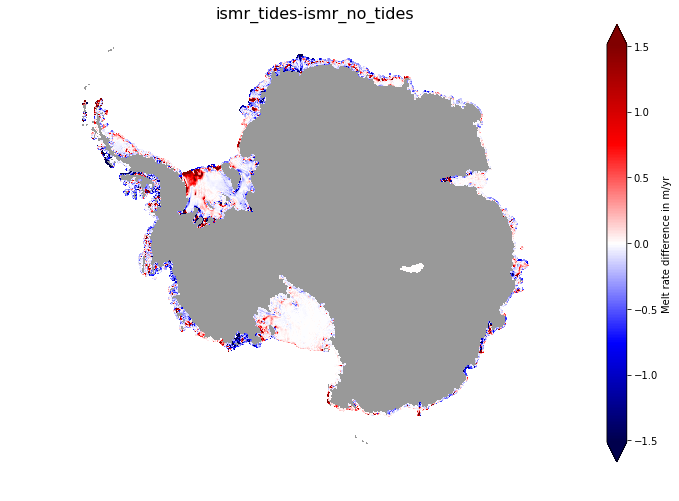

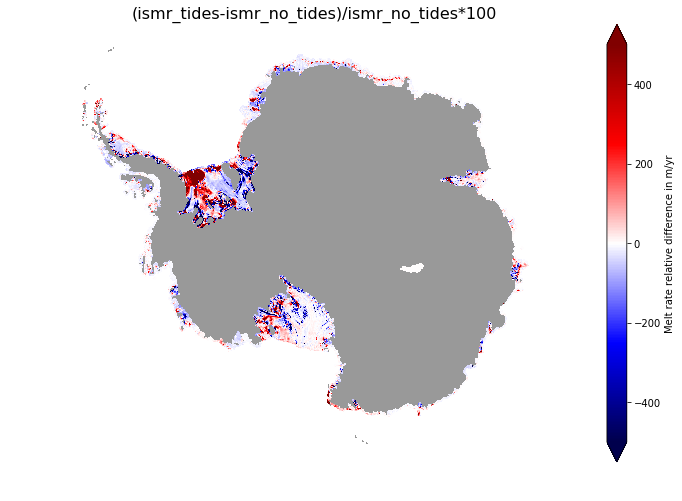

In [261]:
plot_map(m_diff.where(mask)*s2a,grd,'ismr_tides-ismr_no_tides','Melt rate difference in m/yr',
        plt.cm.seismic,save=True)
plot_map(m_diff_rel.where(mask),grd,'(ismr_tides-ismr_no_tides)/ismr_no_tides*100','Melt rate relative difference in m/yr',
        plt.cm.seismic,[-500,500],save=True)

### ice shelf averages

In [281]:
is_avg = pd.DataFrame()

def make_is_avg(da):
    ser = pd.Series()
    for k,v in log_progress(shelves.items(),every=2):
        dA = (grd.pm*grd.pn)**-1
        weights = dA.where(v['mask'])/dA.where(v['mask']).sum()
        ser[k] = (da*weights).sum().values
    return ser
    
is_avg['m_diff'] = make_is_avg(m_diff*s2a) 
is_avg['m_diff_rel'] = make_is_avg(m_diff_rel)

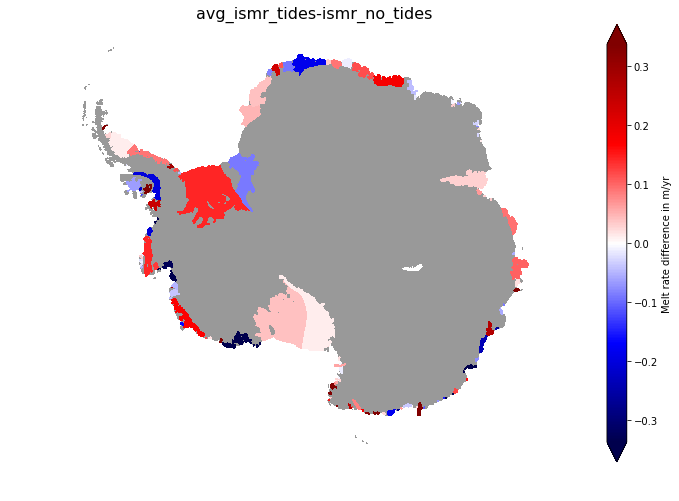

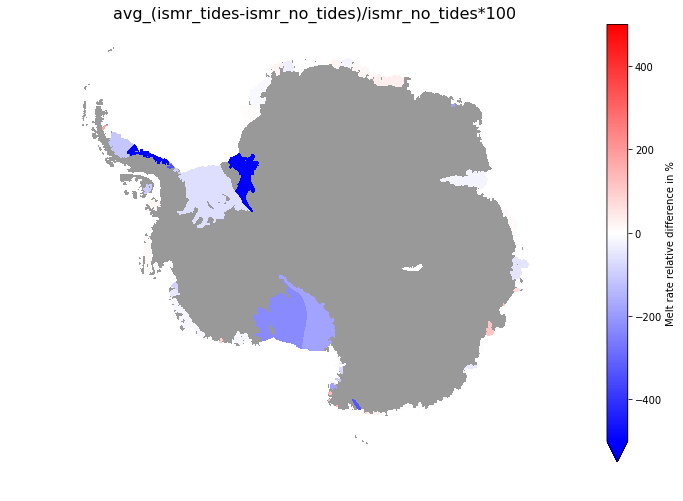

In [282]:
plot_map(make_avg_is_map(is_avg.m_diff),grd,'avg_ismr_tides-ismr_no_tides','Melt rate difference in m/yr',
        plt.cm.seismic,save=False)
plot_map(make_avg_is_map(is_avg.m_diff_rel),grd,'avg_(ismr_tides-ismr_no_tides)/ismr_no_tides*100','Melt rate relative difference in %',
        plt.cm.bwr,[-500,500],save=False)

# ocean temperature

## integrated numbers

In [382]:
mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1000) 

def print_temp_change(layer):
    dV = grd.dV.where(mask_shelf['Total Antarctica']).isel(s_rho=layer)
    weights = dV/dV.sum()
    temp_diff = ((tides.temp-no_tides.temp)*weights).sum().values
    temp_diff_rel = temp_diff/(no_tides.temp*weights).sum().values*100

    print(f'sigma layer: {layer} \ntemp diff (tides-no_tides): {temp_diff} \ntemp_diff_rel (tides-no_tides)/no_tides*100: {temp_diff_rel}')

print_temp_change(slice(0,31))
print_temp_change(0)
print_temp_change(30)

sigma layer: slice(0, 31, None) 
temp diff (tides-no_tides): -0.025544435530531085 
temp_diff_rel (tides-no_tides)/no_tides*100: 2.0869650893967355
sigma layer: 0 
temp diff (tides-no_tides): -0.8673707528344204 
temp_diff_rel (tides-no_tides)/no_tides*100: 2.121437479684894
sigma layer: 30 
temp diff (tides-no_tides): -0.8854311557309066 
temp_diff_rel (tides-no_tides)/no_tides*100: 2.151886247317724


## maps

### full spatial variability

In [333]:
mask = (mask_shelf['Total Antarctica'] == 1) & (grd.mask_rho == 1)
weights = grd.dV.where(mask)/grd.dV.where(mask).sum('s_rho')
wc_temp_diff = ((tides.temp-no_tides.temp)*weights).sum('s_rho').where(mask)
wc_temp_diff_rel = wc_temp_diff/np.abs((no_tides.temp*weights).sum('s_rho'))*100

bl_temp_diff = (tides.temp.isel(s_rho=0) - no_tides.temp.isel(s_rho=0)).where(mask)
bl_temp_diff_rel = bl_temp_diff/no_tides.temp.isel(s_rho=0)*100
sl_temp_diff = (tides.temp.isel(s_rho=30) - no_tides.temp.isel(s_rho=30)).where(mask)
sl_temp_diff_rel = sl_temp_diff/no_tides.temp.isel(s_rho=30)*100

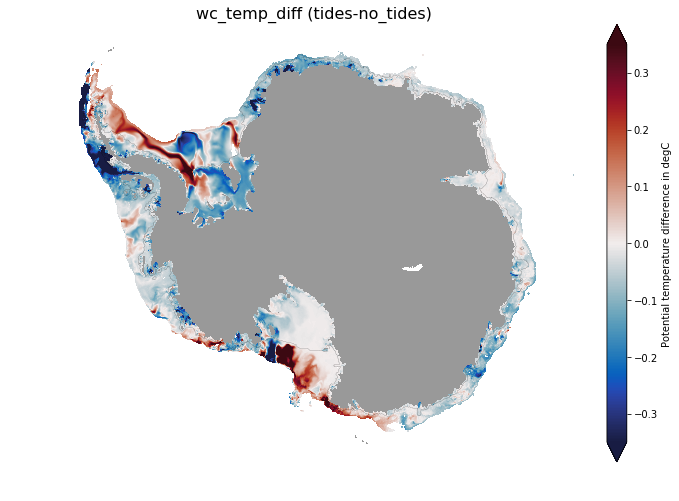

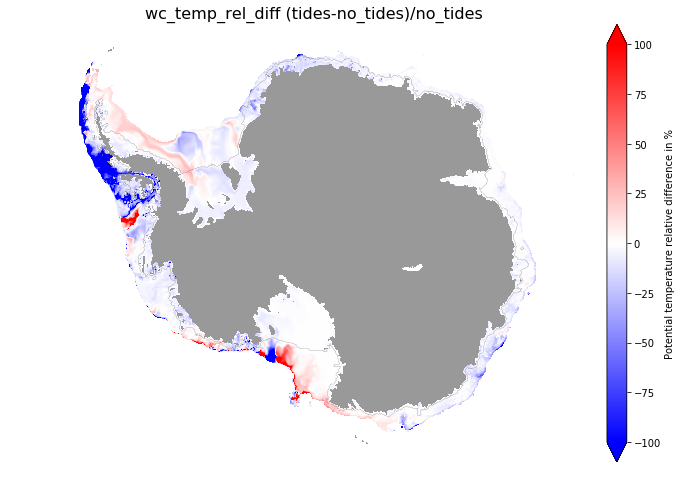

In [340]:
plot_map(wc_temp_diff,grd,'wc_temp_diff (tides-no_tides)','Potential temperature difference in degC',
        ocm.balance,[-0.35,0.35],save=True)
plot_map(wc_temp_diff_rel.where(mask),grd,'wc_temp_rel_diff (tides-no_tides)/no_tides',
         'Potential temperature relative difference in %',
        plt.cm.bwr,[-100,100],save=True)

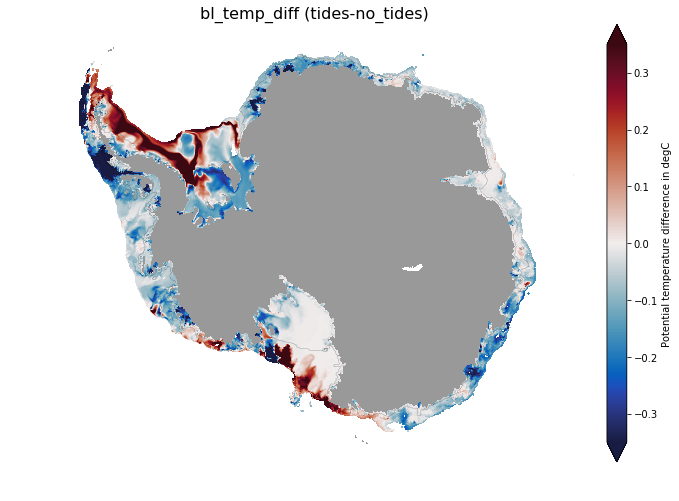

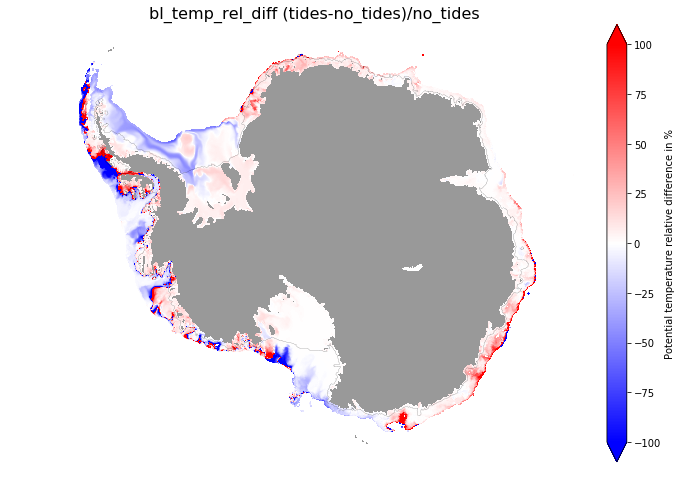

In [341]:
plot_map(bl_temp_diff,grd,'bl_temp_diff (tides-no_tides)','Potential temperature difference in degC',
        ocm.balance,[-0.35,0.35],save=True)
plot_map(bl_temp_diff_rel.where(mask),grd,'bl_temp_rel_diff (tides-no_tides)/no_tides',
         'Potential temperature relative difference in %',
        plt.cm.bwr,[-100,100],save=True)

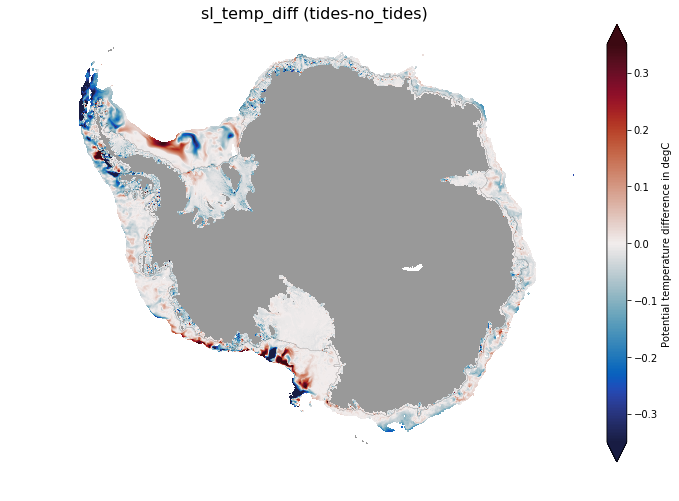

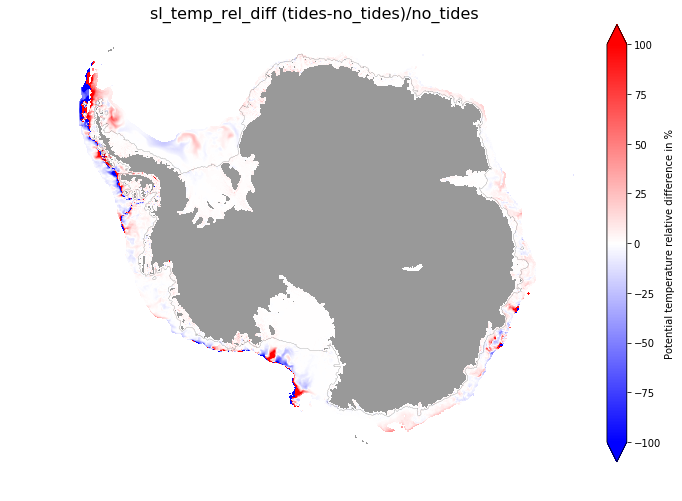

In [342]:
plot_map(sl_temp_diff,grd,'sl_temp_diff (tides-no_tides)','Potential temperature difference in degC',
        ocm.balance,[-0.35,0.35],save=True)
plot_map(sl_temp_diff_rel.where(mask),grd,'sl_temp_rel_diff (tides-no_tides)/no_tides',
         'Potential temperature relative difference in %',
        plt.cm.bwr,[-100,100],save=True)

### averages

In [ ]:
sec_avg = pd.DataFrame()

def make_sec_avg(da):
    ser = pd.Series()
    for k,v in log_progress(mask_sector.items(),every=2):
        dA = (grd.pm*grd.pn)**-1
        weights = dA.where(v)/dA.where(v).sum()
        ser[k] = (da*weights).sum().values
    return ser
    
def make_avg_sec_map(df):
    sec_map = np.zeros_like(grd.mask_rho)
    mask_map = np.zeros_like(sec_map)
    for k,v in df.iteritems():
        sec_map[mask_shelf[k]]=v
        mask_map[mask_shelf[k]]=1
        
    return xr.DataArray(sec_map,dims=('eta_rho','xi_rho')).where(mask_map)

sec_avg['wc_temp_diff'] = make_sec_avg(wc_temp_diff) 
sec_avg['wc_temp_diff_rel'] = make_sec_avg(wc_temp_diff_rel)
sec_avg['bl_temp_diff'] = make_sec_avg(bl_temp_diff) 
sec_avg['bl_temp_diff_rel'] = make_sec_avg(bl_temp_diff_rel)
sec_avg['sl_temp_diff'] = make_sec_avg(sl_temp_diff) 
sec_avg['sl_temp_diff_rel'] = make_sec_avg(sl_temp_diff_rel)

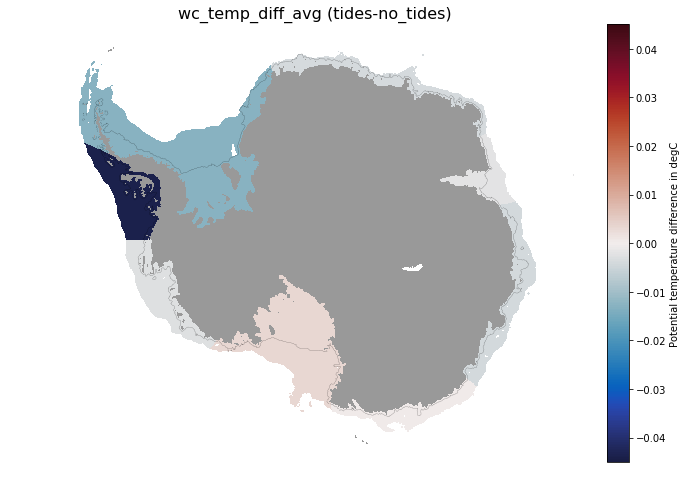

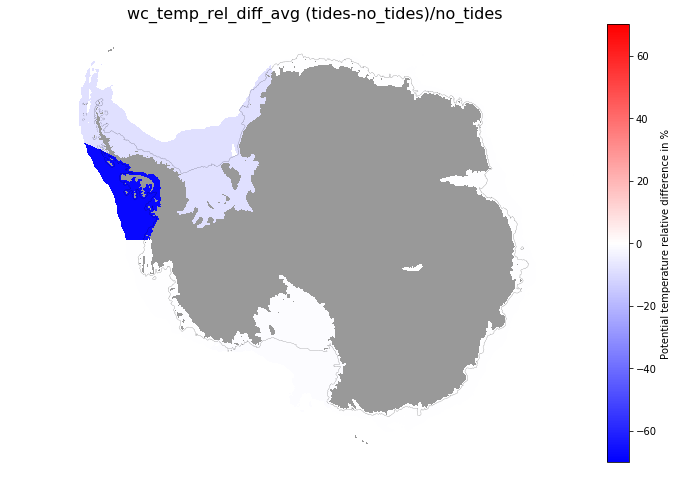

In [364]:
plot_map(make_avg_sec_map(sec_avg.wc_temp_diff.drop('Total Antarctica')),grd,'wc_temp_diff_avg (tides-no_tides)','Potential temperature difference in degC',
        ocm.balance,0.045,save=False)
plot_map(make_avg_sec_map(sec_avg.wc_temp_diff_rel.drop('Total Antarctica')),grd,'wc_temp_rel_diff_avg (tides-no_tides)/no_tides',
         'Potential temperature relative difference in %',
        plt.cm.bwr,70,save=False)

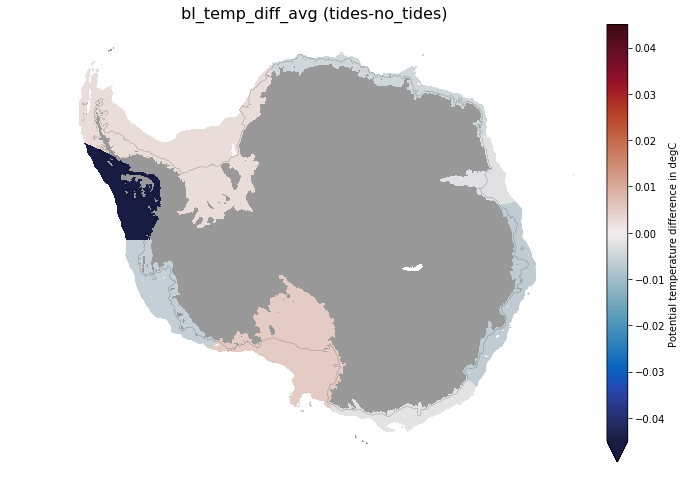

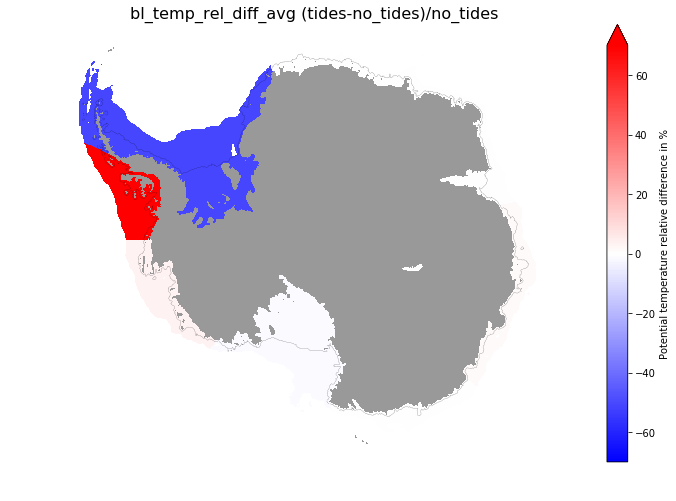

In [365]:
plot_map(make_avg_sec_map(sec_avg.bl_temp_diff.drop('Total Antarctica')),grd,'bl_temp_diff_avg (tides-no_tides)','Potential temperature difference in degC',
        ocm.balance,0.045,save=True)
plot_map(make_avg_sec_map(sec_avg.bl_temp_diff_rel.drop('Total Antarctica')),grd,'bl_temp_rel_diff_avg (tides-no_tides)/no_tides',
         'Potential temperature relative difference in %',
        plt.cm.bwr,70,save=True)

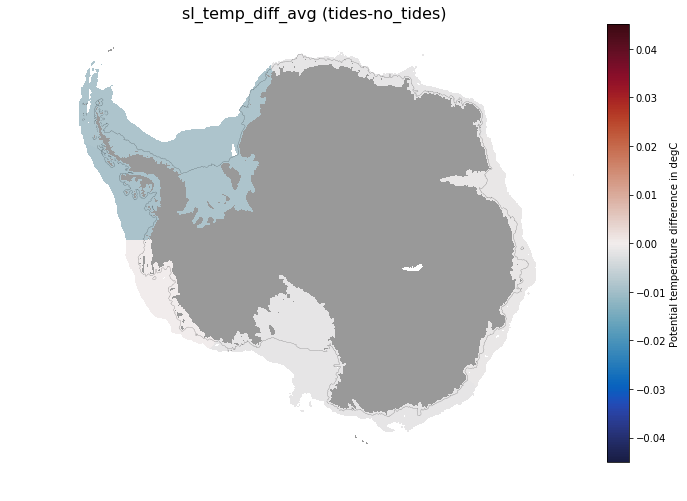

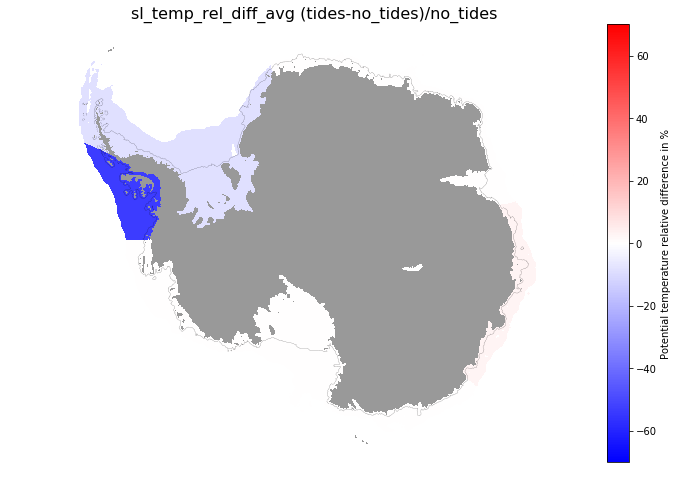

In [366]:
plot_map(make_avg_sec_map(sec_avg.sl_temp_diff.drop('Total Antarctica')),grd,'sl_temp_diff_avg (tides-no_tides)','Potential temperature difference in degC',
        ocm.balance,0.045,save=True)
plot_map(make_avg_sec_map(sec_avg.sl_temp_diff_rel.drop('Total Antarctica')),grd,'sl_temp_rel_diff_avg (tides-no_tides)/no_tides',
         'Potential temperature relative difference in %',
        plt.cm.bwr,70,save=True)

In [ ]:
mask = ((grd.zice<0) & (grd.mask_rho==1))

for ds in [tides,no_tides]:    
    ds['Sm'] = ds.salt.isel(s_rho=30).where(mask).squeeze()   
    ds['ustar'] = calc_ustar(ds.u,ds.v,mask)
    ds['Tdr'],ds['Tfr'] = calc_frc(ds.Tm,ds.Sm,grd.zice,ds.ustar,grd.f.where(mask),ds.m,mask)
    
Tm = xr.open_dataarray(os.path.join(int_dir,'situTemp4.nc')).where(mask)

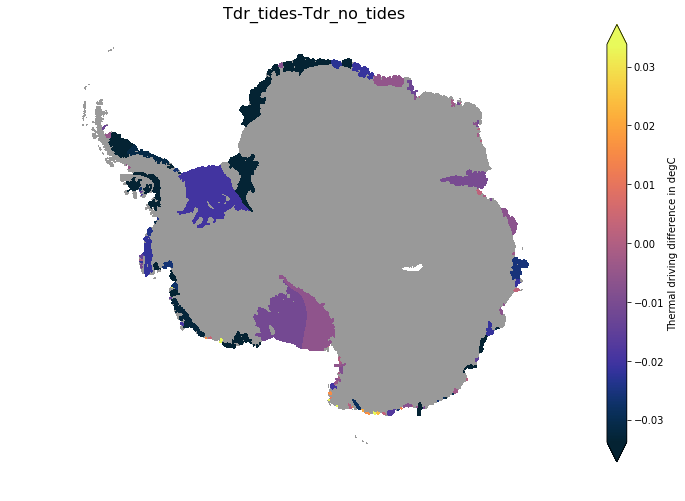

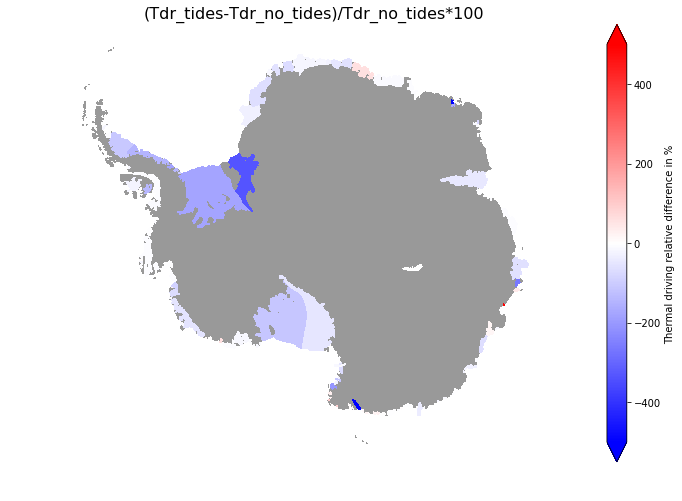

In [259]:
Tdr_diff = tides.Tdr-no_tides.Tdr
Tdr_diff_rel = Tdr_diff/np.abs(no_tides.Tdr)*100

ustar_diff = (tides.ustar+tides.ustar_rms)-no_tides.ustar
ustar_diff_rel = ustar_diff/np.abs(no_tides.ustar)*100
plot_map(make_avg_is_map(is_avg.Tdr_diff),grd,'Tdr_tides-Tdr_no_tides','Thermal driving difference in degC',
        ocm.thermal,save=True)
plot_map(make_avg_is_map(is_avg.Tdr_diff_rel),grd,'(Tdr_tides-Tdr_no_tides)/Tdr_no_tides*100','Thermal driving relative difference in %',
        plt.cm.bwr,[-500,500],save=True)

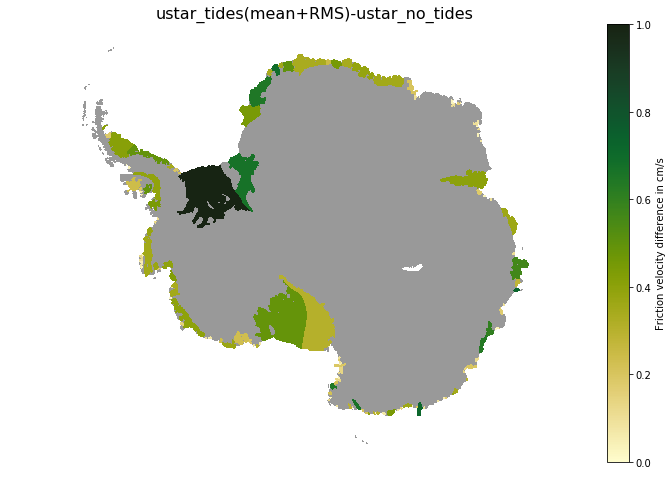

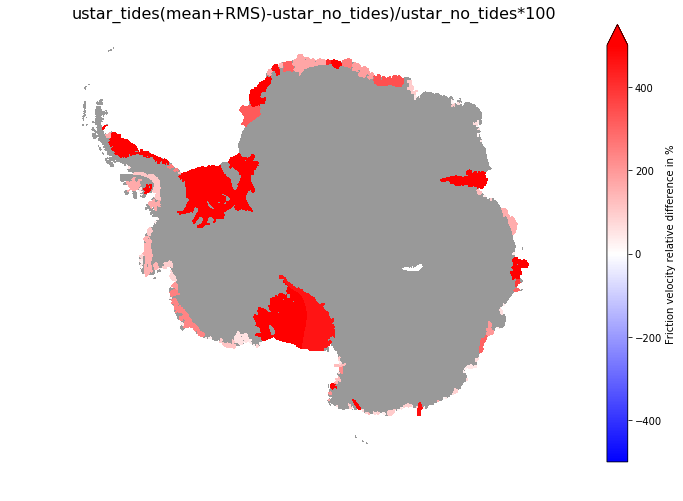

In [260]:
plot_map(make_avg_is_map(is_avg.ustar_diff)*100,grd,'ustar_tides(mean+RMS)-ustar_no_tides','Friction velocity difference in cm/s',
        ocm.speed,[0,1],save=True)
plot_map(make_avg_is_map(is_avg.ustar_diff_rel),grd,'ustar_tides(mean+RMS)-ustar_no_tides)/ustar_no_tides*100','Friction velocity relative difference in %',
        plt.cm.bwr,[-500,500],save=True)

# Velovities

# Thermal driving and frcition velocity

# old stuff

## combined maps

In [226]:
mask = ((grd.zice<0) & (grd.mask_rho==1))
tides['Tm'] = xr.open_dataarray(os.path.join(int_dir,'situTemp4.nc')).where(mask)
no_tides['Tm'] = xr.open_dataarray(os.path.join(int_dir,'situTemp4_nt.nc')).where(mask)

for ds in [tides,no_tides]:    
    ds['Sm'] = ds.salt.isel(s_rho=30).where(mask).squeeze()   
    ds['ustar'] = calc_ustar(ds.u,ds.v,mask)
    ds['Tdr'],ds['Tfr'] = calc_frc(ds.Tm,ds.Sm,grd.zice,ds.ustar,grd.f.where(mask),ds.m,mask)
    
tides['rms_ustar'] = (tidal_velo*np.sqrt(5.0e-3)) 

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [179]:


def plot_map(da_is,da_oo,grd,title,cbl_is,cbl_oo,cmap_is,cmap_oo,vrange_is=None,vrange_oo=None,save=False):

    vmin_is,vmax_is = vrange(da_is,vrange_is)
    vmin_oo,vmax_oo = vrange(da_oo,vrange_oo)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(10,6))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    
    da_is.where(mask_is).plot(ax=ax,vmin=vmin_is,vmax=vmax_is,cmap=cmap_is,cbar_kwargs={'label': cbl_is})
    da_oo.where(mask_oo).plot(ax=ax,vmin=vmin_oo,vmax=vmax_oo,cmap=cmap_oo,cbar_kwargs={'label': cbl_oo})
    
    ax.contour((grd.zice <0) & (grd.mask_rho == 1), levels=['0.05'], colors=('black'),linewidths=0.2)
    
    ax.set_title('')
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',dpi=300,bbox_inches = "tight")
    plt.show()

In [41]:
mask_is = (grd.zice < 0.0) & (grd.mask_rho==1)
mask_oo = (grd.mask_rho==1) & (grd.zice == 0.0) 

weights = grd.dV.where(mask_oo)/grd.dV.where(mask_oo).sum('s_rho')

m_diff = (tides.m-no_tides.m).where(mask_is)
temp_diff = ((tides.temp-no_tides.temp)*weights).sum('s_rho')

m_diff_rel = m_diff/np.abs(no_tides.m)*100
temp_diff_rel = temp_diff/np.abs((no_tides.temp*weights).sum('s_rho'))*100

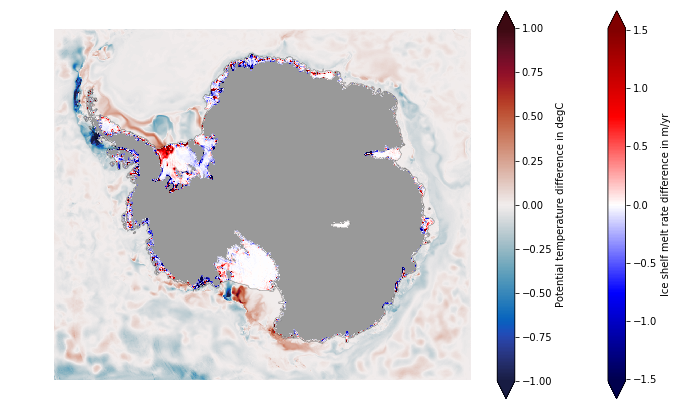

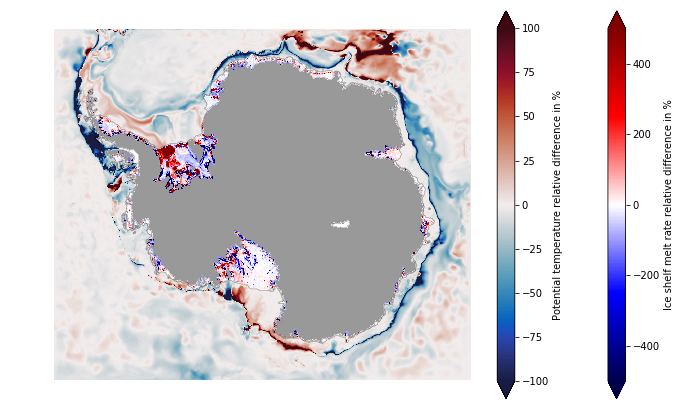

In [180]:
plot_map(m_diff*s2a,temp_diff,grd,
         'ismr_temp_abs',
         'Ice shelf melt rate difference in m/yr','Potential temperature difference in degC',plt.cm.seismic,ocm.balance,vrange_oo=[-1,1],
        save=True) 

plot_map(m_diff_rel,temp_diff_rel,grd,
         'ismr_temp_rel',
         'Ice shelf melt rate relative difference in %','Potential temperature relative difference in %',plt.cm.seismic,ocm.balance,[-500,500],[-100,100],
        save=True)

## Ice shelf and sector averages

In [115]:
from scipy.ndimage.morphology import binary_dilation as bd

def make_open_ocean_mask(shelves_dict,grd,iterations=10):
    for key,data in log_progress(shelves_dict.items(),every=2):
        mask_is = data['mask']
        mask_bd = bd(mask_is,iterations=iterations)
        mask_fr = (mask_bd) & (~mask_is) & (grd.mask_rho==1) & (grd.zice==0) 
        shelves_dict[key]['mask_ocean'] = xr.DataArray(mask_fr==1,dims=('eta_rho','xi_rho'))
    return shelves_dict

shelves = make_open_ocean_mask(shelves,grd)

In [150]:
sec_avg = pd.DataFrame(index=[k for k,v in mask_sector.items()],columns=['m_diff','m_diff_rel','temp_diff','temp_diff_rel'])
mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector) 

for k,v in mask_shelf.items():
    dA = (grd.pm*grd.pn)**-1
    weights = dA.where(v)/dA.where(v).sum()
    sec_avg['temp_diff'][k] = (temp_diff*weights).sum().values
    sec_avg["temp_diff_rel"][k] = (temp_diff_rel*weights).sum().values      
    dA = (grd.pm*grd.pn)**-1
    mask = (v==1) & (grd.zice<0) & (grd.mask_rho==1)
    if mask.any()==False:
        print(k)
    weights = dA.where(mask)/dA.where(mask).sum()
    sec_avg['m_diff'][k] = (m_diff*weights).sum().values
    sec_avg['m_diff_rel'][k] = (m_diff_rel*weights).sum().values

is_avg = pd.DataFrame(index=[k for k,v in shelves.items()],columns=['m_diff','m_diff_rel','temp_diff','temp_diff_rel'])

for k,v in shelves.items():
    dA = (grd.pm*grd.pn)**-1
    weights = dA.where(v['mask'])/dA.where(v['mask']).sum()
    is_avg['m_diff'][k] = (m_diff*weights).sum().values
    is_avg['m_diff_rel'][k] = (m_diff_rel*weights).sum().values
    weights = dA.where(v['mask_ocean'])/dA.where(v['mask_ocean']).sum()
    is_avg['temp_diff'][k] = (temp_diff*weights).sum().values
    is_avg['temp_diff_rel'][k] = (temp_diff_rel*weights).sum().values

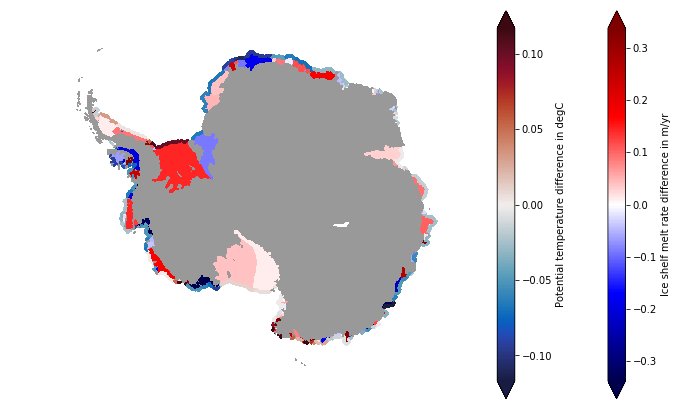

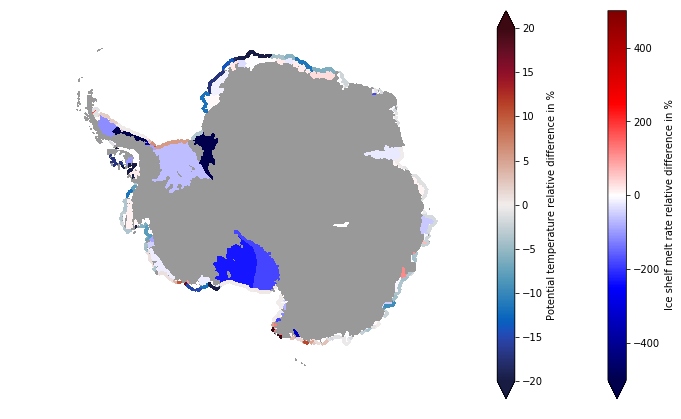

In [164]:
def make_avg_is_map(df):
    shelf_map = np.zeros_like(grd.mask_rho)
    mask_map = np.zeros_like(shelf_map)
    for k,v in df.iteritems():
        shelf_map[shelves[k]['mask']]=v
        mask_map[shelves[k]['mask']]=1
        
    return xr.DataArray(shelf_map,dims=('eta_rho','xi_rho')).where(mask_map)

def make_avg_oo_map(df):
    oo_map = np.zeros_like(grd.mask_rho)
    mask_map = np.zeros_like(oo_map)
    for k,v in df.iteritems():
        oo_map[shelves[k]['mask_ocean']]=v
        mask_map[shelves[k]['mask_ocean']]=1
        
    return xr.DataArray(oo_map,dims=('eta_rho','xi_rho')).where(mask_map)

plot_map(make_avg_is_map(is_avg.m_diff)*s2a,make_avg_oo_map(is_avg.temp_diff),grd,
         '',
         'Ice shelf melt rate difference in m/yr','Potential temperature difference in degC',
         plt.cm.seismic,ocm.balance,
         save=True)

plot_map(make_avg_is_map(is_avg.m_diff_rel),make_avg_oo_map(is_avg.temp_diff_rel),grd,
         '',
         'Ice shelf melt rate relative difference in %','Potential temperature relative difference in %',
         plt.cm.seismic,ocm.balance,vrange_is=[-500,500],vrange_oo=[-20,20],
         save=True)

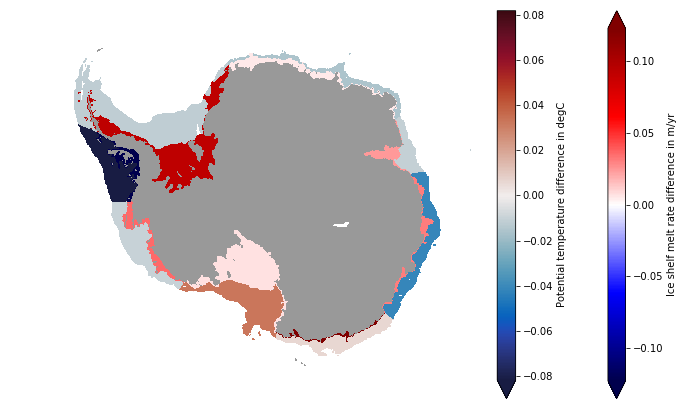

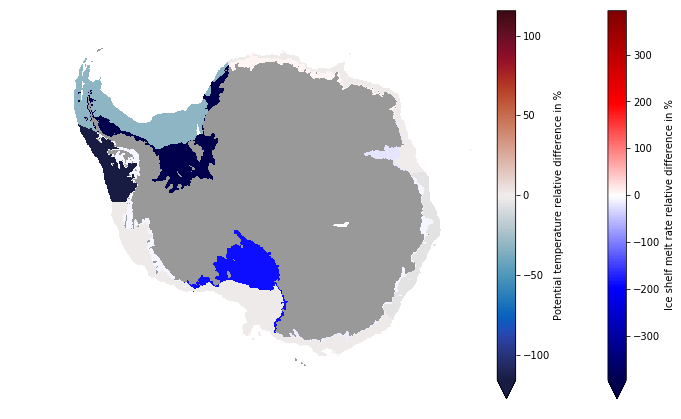

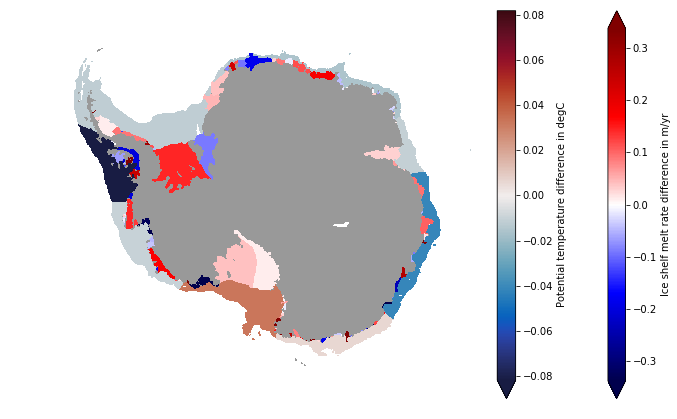

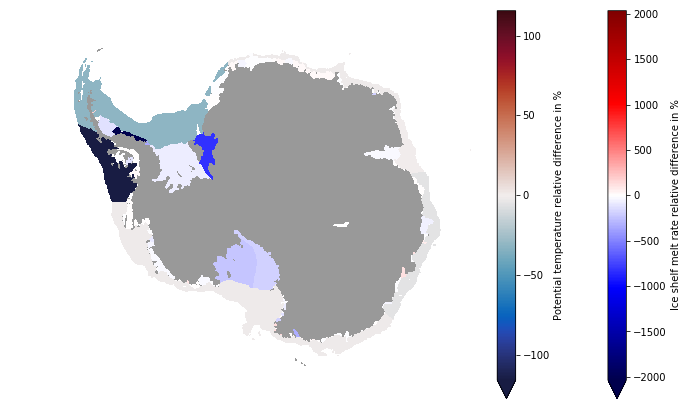

In [165]:
def make_avg_seco_map(df):
    sec_map = np.zeros_like(grd.mask_rho)
    mask_map = np.zeros_like(sec_map)
    for k,v in df.iteritems():
        sec_map[mask_shelf[k]]=v
        mask_map[mask_shelf[k]]=1
        
    return xr.DataArray(sec_map,dims=('eta_rho','xi_rho')).where(mask_map)

def make_avg_secis_map(df):
    sec_map = np.zeros_like(grd.mask_rho)
    mask_map = np.zeros_like(sec_map)
    for k,v in df.iteritems():
        mask = (mask_shelf[k]) & (grd.zice<0) & (grd.mask_rho==1)
        sec_map[mask]=v
        mask_map[mask]=1
        
    return xr.DataArray(sec_map,dims=('eta_rho','xi_rho')).where(mask_map)

plot_map(make_avg_secis_map(sec_avg.m_diff*s2a),make_avg_seco_map(sec_avg.temp_diff),grd,
         '',
         'Ice shelf melt rate difference in m/yr','Potential temperature difference in degC',
         plt.cm.seismic,ocm.balance,
         save=False)
plot_map(make_avg_secis_map(sec_avg.m_diff_rel),make_avg_seco_map(sec_avg.temp_diff_rel),grd,
         '',
         'Ice shelf melt rate relative difference in %','Potential temperature relative difference in %',
         plt.cm.seismic,ocm.balance,
         save=False)

plot_map(make_avg_is_map(is_avg.m_diff*s2a),make_avg_seco_map(sec_avg.temp_diff),grd,
         '',
         'Ice shelf melt rate difference in m/yr','Potential temperature difference in degC',
         plt.cm.seismic,ocm.balance,
         save=False)
plot_map(make_avg_is_map(is_avg.m_diff_rel),make_avg_seco_map(sec_avg.temp_diff_rel),grd,
         '',
         'Ice shelf melt rate relative difference in %','Potential temperature relative difference in %',
         plt.cm.seismic,ocm.balance,
         save=False)

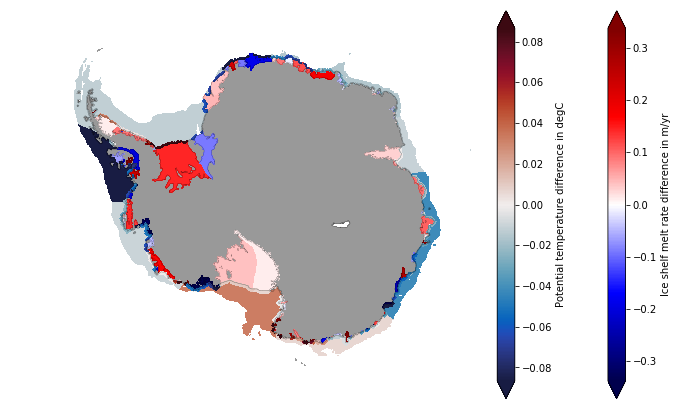

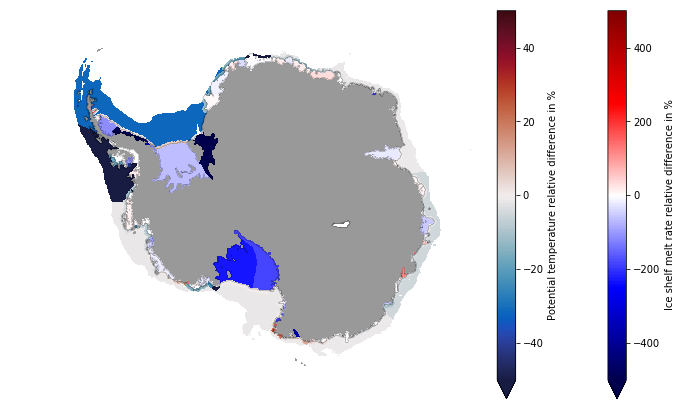

In [181]:
def make_avg_secoo_map(df_oo,df_o):
    sec_map = np.zeros_like(grd.mask_rho)
    mask_map = np.zeros_like(sec_map)
    for k,v in df_oo.iteritems():
        sec_map[mask_shelf[k]]=v
        mask_map[mask_shelf[k]]=1
        
    for k,v in df_o.iteritems():
        sec_map[shelves[k]['mask_ocean']]=v
        
    return xr.DataArray(sec_map,dims=('eta_rho','xi_rho')).where(mask_map)

plot_map(make_avg_is_map(is_avg.m_diff*s2a),make_avg_secoo_map(sec_avg.temp_diff,is_avg.temp_diff),grd,
         'ismr_temp_avg_abs',
         'Ice shelf melt rate difference in m/yr','Potential temperature difference in degC',
         plt.cm.seismic,ocm.balance,
         save=True)
plot_map(make_avg_is_map(is_avg.m_diff_rel),make_avg_secoo_map(sec_avg.temp_diff_rel,is_avg.temp_diff_rel),grd,
         'ismr_temp_avg_rel',
         'Ice shelf melt rate relative difference in %','Potential temperature relative difference in %',
         plt.cm.seismic,ocm.balance,[-500,500],[-50,50],
         save=True)

In [42]:
calc_antarctic_mass_loss(tides.m-no_tides.m,grd)

Area of all ice shelves in 10^3 km^2:  1690.8425444117381
Area average melt rate in m/yr:  0.036581509390381815
Basal mass loss in Gt/a:  56.65787233310646


## sector wise

In [25]:
def calc_mass_loss(m,grd,mask):

    s2a = 3600*24*365.25
    rhoi = 916

    ice_shelf = (grd.mask_rho==1) & (grd.zice<0.0)
    vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)

    mask = ice_shelf & ~vostock & mask

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()

    A = (dA.sum().load())*10**-9
    ismr = (m.where(mask)*weights*s2a).sum().load()
    bmb = (m.where(mask)*dA*rhoi*s2a*10**-12).sum().load()

    #print('Area of all ice shelves in 10^3 km^2: %.2f'%A.values)
    #print('Area average melt rate in m/yr: %.2f'%ismr.values)
    #print('Basal mass loss in Gt/a: %.2f'%bmb.values)
    
    return bmb,ismr,A

In [ ]:
sectors_dict = {}
for k,v in mask_sector.items():
    print('\n'+k)
    bmb,ismr,A = calc_mass_loss(tides.m-no_tides.m,grd,v)
    sectors_dict[k]={}
    sectors_dict[k]['bmb'] = bmb.values
    sectors_dict[k]['ismr'] = ismr.values
    sectors_dict[k]['A'] = A.values

In [50]:
def calc_shelf_temp(temp,grd,mask):
    weights = grd.dV*mask/(grd.dV*mask.sum())
    temp = (temp*weights).sum().load()
    return temp

In [55]:
for k,v in log_progress(mask_shelf.items(),every=2):
    sectors_dict[k]['temp'] = calc_shelf_temp(tides.temp-no_tides.temp,grd,v).values

In [152]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame.from_dict(sectors_dict,orient='index').astype(float)
df = df.rename(index={'George V Coast/Wilkes subglacial basin':'George V Coast',
                 'Sabrina Coast/Aurora subglacial basin':'Sabrina Coast','Amery/Prydz Bay':'Prydz Bay'})
df.to_csv(os.path.join(tab_dir,'sector_Delta_all.csv'))

In [153]:
df = df.loc[['Bellingshausen Sea','Amundsen Sea','Ross Sea','George V Coast','Sabrina Coast','Prydz Bay',
        'Western East Antarctica','Weddell Sea']]

<IPython.core.display.Javascript object>


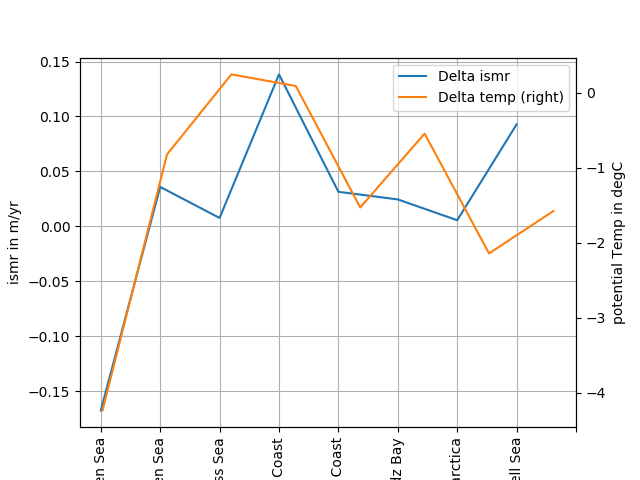

In [154]:
%matplotlib notebook
plt.close()
ax1 = df.plot(y='ismr',label='Delta ismr')
ax2 = df.plot(y='temp',ax=ax1,secondary_y=True,label='Delta temp',xticks=range(9),rot=90)
ax1.set_ylabel('ismr in m/yr')
ax2.set_ylabel('potential Temp in degC')
ax1.grid()
plt.savefig(os.path.join(fig_dir,'sector_Delta_ismrTemp.png'),bbox_inches='tight')
plt.show()

## ice shelf wise

In [4]:
shelves_path = os.path.join(int_dir,'shelves4.npy')
shelves = np.load(shelves_path).item()

In [18]:
for k,v in log_progress(shelves.items(),name='ice shelf'):
    
    bmb,ismr,A = calc_mass_loss(tides.m-no_tides.m,grd,v['mask'])
    
    shelves[k]['Dbmb'] = bmb
    shelves[k]['Dismr'] = ismr
    shelves[k]['DA'] = A
    
    bmb_nt,ismr_nt,A = calc_mass_loss(no_tides.m,grd,v['mask'])
    
    shelves[k]['Dbmb_rel'] = bmb/np.abs(bmb_nt)
    shelves[k]['Dismr_rel'] = ismr/np.abs(ismr_nt)
    
dict_out_path = os.path.join(int_dir,'shelves4.npy')
np.save(dict_out_path,shelves)

In [59]:
shelves_melt = {}
for k,v in shelves.items():
    shelves_melt[k] = {k:v for k,v in v.items() if k in ['bmb','A','ismr','lon_mid','bmb_rel','ismr_rel']}
import pandas as pd
df_shelves = pd.DataFrame.from_dict(shelves_melt,orient='index').astype('float').sort_values('lon_mid')

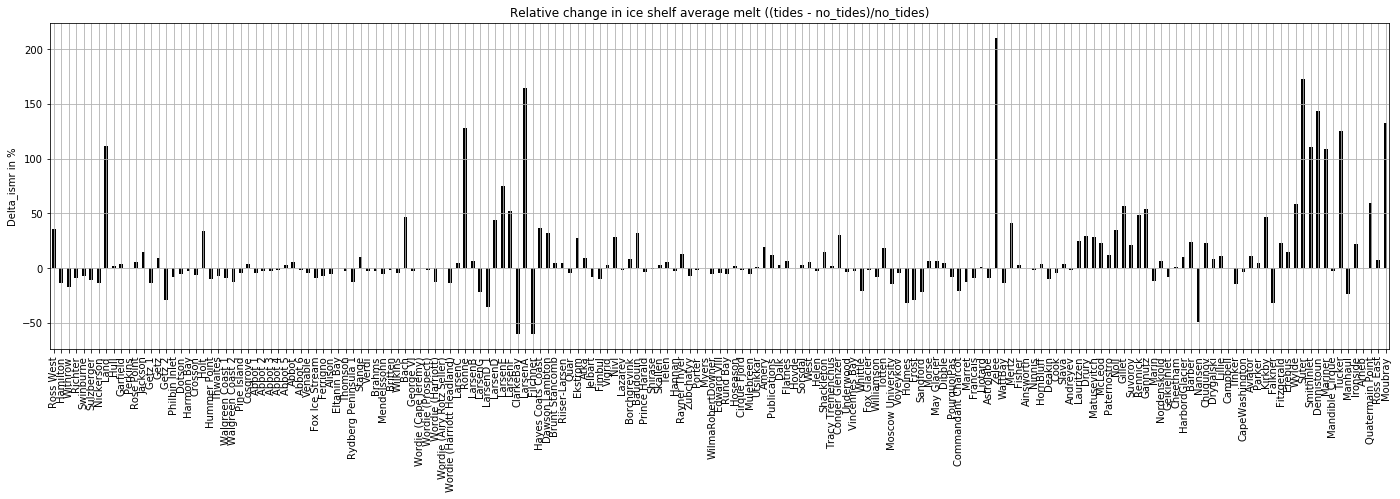

In [65]:
%matplotlib inline
plt.close()
fig,ax = plt.subplots(figsize=(24,6))
(df_shelves.ismr_rel*100).plot.bar(ax=ax,color='k')
ax.grid()
ax.set_ylabel('Delta_ismr in %')
ax.set_title('Relative change in ice shelf average melt ((tides - no_tides)/no_tides)')
plt.savefig(os.path.join(fig_dir,'shelves_all_Delta_ismr_rel.png'),bbox_inches='tight')
plt.show()

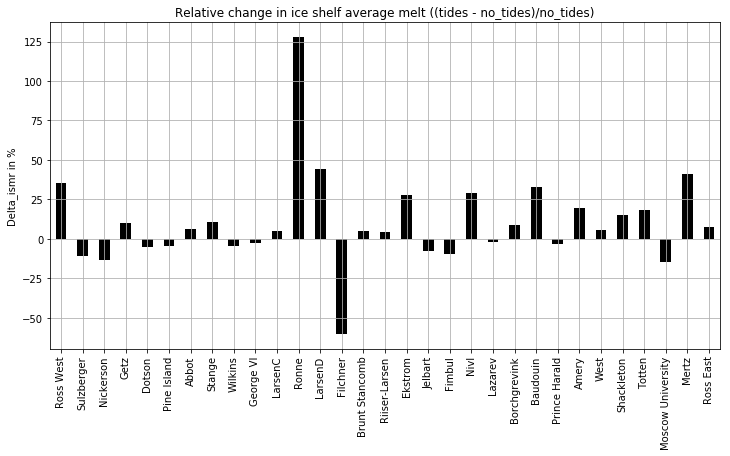

In [67]:
%matplotlib inline
df_big_shelves = df_shelves.loc[df_shelves['A'] >= 5.0]

plt.close()
fig,ax = plt.subplots(figsize=(12,6))
(df_big_shelves.ismr_rel*100).plot.bar(ax=ax,color='k')
ax.grid()
ax.set_ylabel('Delta_ismr in %')
ax.set_title('Relative change in ice shelf average melt ((tides - no_tides)/no_tides)')
plt.savefig(os.path.join(fig_dir,'shelves_big_Delta_ismr_rel.png'),bbox_inches='tight')
plt.show()

In [75]:
plt.rcParams.update({'font.size': 12})
def make_avg_map(quant,grd,shelves_dict):
    shelf_map = np.zeros_like(grd.mask_rho)
    for key,values in log_progress(shelves_dict.items(),every=2):
        shelf_map[values['mask']]=values[quant]
        
    return xr.DataArray(shelf_map,dims=('eta_rho','xi_rho')).where((grd.zice<0)&(grd.mask_rho==1))

def map_shelves_avg(quant,shelves_dict,grd,title,cbar_label,cmap,vrange=None):
    
    avg_map = make_avg_map(quant,grd,shelves_dict)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(10,6))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    if vrange==None:
        #vmin = avg_map.min()
        #vmax = avg_map.max()
        mean = avg_map.mean(dim=avg_map.dims)
        std = avg_map.std(dim=avg_map.dims)
        vmin=max(avg_map.min(),mean-2*std)
        vmax=min(avg_map.max(),mean+2*std)
    else:
        vmin,vmax=vrange
        
    cmap = shiftedColorMap(plt.cm.seismic,midpoint = (1 - vmax/(vmax + abs(vmin))))
    plot = avg_map.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label': cbar_label})
    ax.set_title(title)
    #ax.grid()
    ax.set_ylim([130,1250])
    ax.set_xlim([60,1450])
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,'map_Delta_ismr_shelf_avg.png'),format='png',dpi=300,bbox_inches = "tight")
    plt.show()

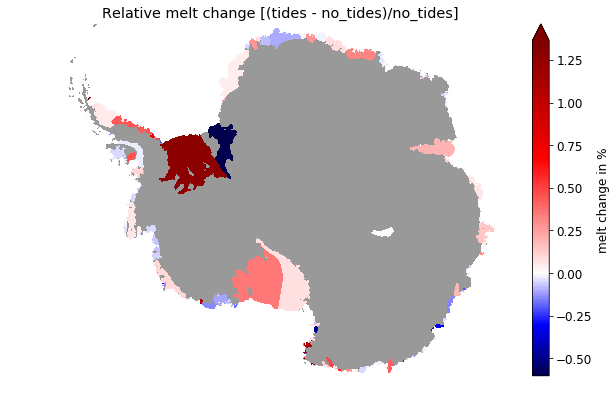

In [106]:
map_shelves_avg('ismr_rel',shelves,grd,'Relative melt change [(tides - no_tides)/no_tides]','melt change in %',plt.cm.seismic)

# Pattern discovery
## Depth and slope

In [231]:
grad_eta = np.zeros_like(grd.mask_rho)
grad_xi = np.zeros_like(grd.mask_rho)

for xi in grd.xi_rho:
    grad_eta[:,xi] = np.gradient(grd.zice[:,xi],np.cumsum(grd.pn[:,xi]**-1))
    
for eta in grd.eta_rho:
    grad_xi[eta,:] = np.gradient(grd.zice[eta,:],np.cumsum(grd.pm[eta,:]**-1))
    
magGradz = np.sqrt(grad_eta**2 + grad_xi**2)
grd['gradZice'] = xr.DataArray(magGradz,dims=('eta_rho','xi_rho'),name='gradzice').where((grd.mask_rho==1)&(grd.zice<0))

<IPython.core.display.Javascript object>


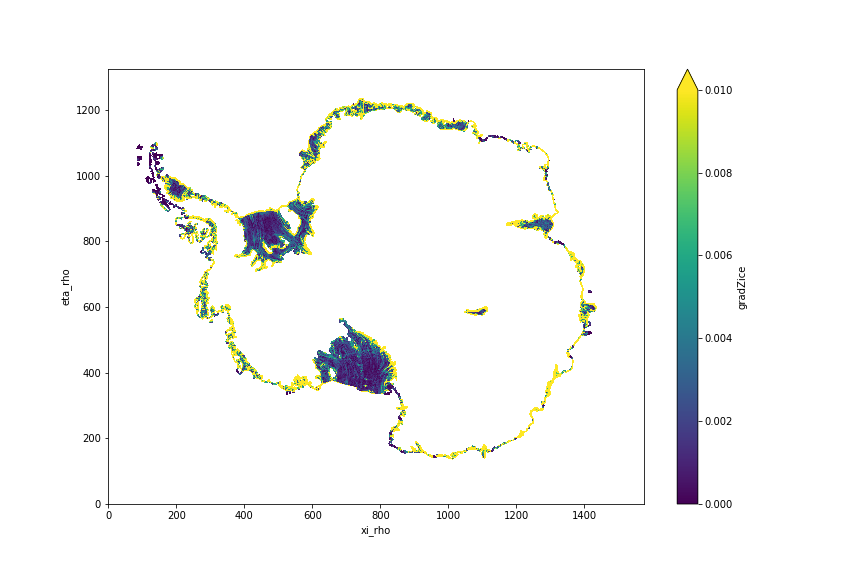

In [236]:
plt.close()
grd.gradZice.plot(size=8,vmax=0.01)

In [65]:
s2a=3600*24*365.25

def scatter(x_quant,xlab,title,xlim=False,ylim=False,save=False, mask = (grd.mask_rho==1) & (grd.zice < 0.0)):
    
    y = (tides.m-no_tides.m).values[mask]*s2a
    x = x_quant.values[mask]

    plt.close()
    fig,ax = plt.subplots(figsize=(10,8))
    plt.plot(x,y,'k.',ms=0.5)
    plt.xlabel(xlab)
    plt.ylabel('ismr in m/yr')
    plt.title(title)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if save:
        plt.savefig(os.path.join(fig_dir,'scatter_'+title.replace(' ','_')+'.png'),dpi=300)
    plt.show()

<IPython.core.display.Javascript object>


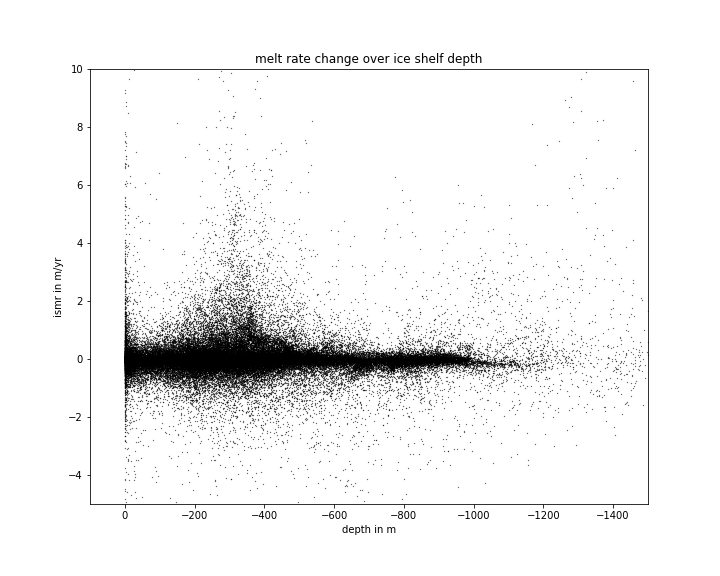

In [245]:
scatter(grd.zice,'depth in m','melt rate change over ice shelf depth',(100,-1500),(-5,10))

<IPython.core.display.Javascript object>


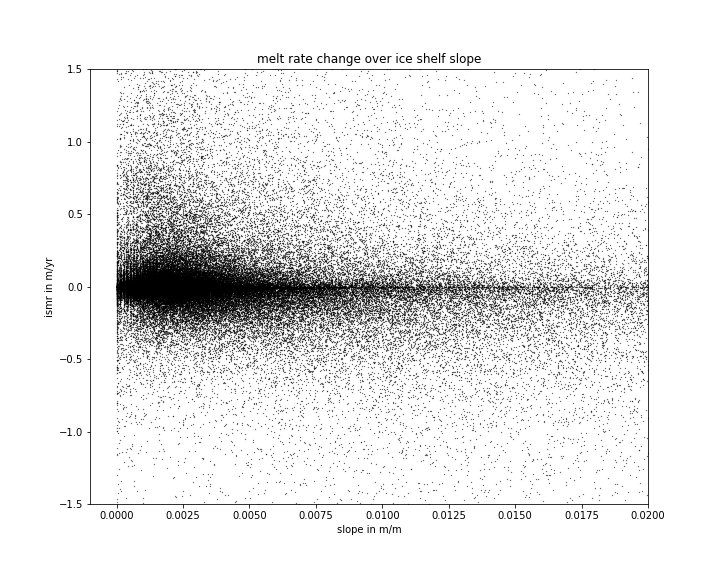

In [246]:
scatter(grd.gradZice,'slope in m/m','melt rate change over ice shelf slope',xlim=(-0.001,0.02),ylim=(-1.5,1.5))

In [131]:
depths = grd.zice*-1
mask = (grd.zice<0) & (grd.mask_rho==1)
dA = (1/(grd.pm*grd.pn)).where(mask)
rhoi = 916
ismr2bmb = dA*rhoi*(10**-12)
s2a = 365.25 * 24 * 3600

In [66]:
def make_bins(bin_quant,low,high,steps,mask=(grd.mask_rho==1) & (grd.zice < 0.0)):
    
    bins = np.linspace(low,high,steps)
    sep=(high-low)/steps
    
    dm = (tides.m-no_tides.m).where(mask)
    dA = ((grd.pm*grd.pn)**-1).where(mask)

    Ab = []
    dmb = []
    dbmbb = []

    s2a = 3600*24*365.25
    rhoi = 916
    ismr2bmb = dA*rhoi*(10**-12)

    for b in log_progress(bins):

        mask = (bin_quant > b) & (bin_quant <= b+sep)
        weights = dA.where(mask)/dA.where(mask).sum()

        Ab.append(dA.where(mask).sum().values*10**-9)
        dmb.append((dm*weights).sum().values)
        dbmbb.append((dm.where(mask)*ismr2bmb*s2a).sum().values) 
    
    return dmb,dbmbb,Ab

In [67]:
def bar_bin(dmb,dbmbb,Ab,bins,title,xlab,save=False):
    plt.close()
    fig,axes = plt.subplots(3,figsize=(8,8))
    ax1,ax2,ax3 = axes.flatten()
    bw = (bins[1]-bins[0])/3
    ax1.bar(bins,dmb,bw,color='k')
    ax2.bar(bins,dbmbb,bw,color='k')
    ax3.bar(bins,Ab,bw,color='k')
    ax1.set_ylabel('Delta ismr in m/yr')
    ax2.set_ylabel('Delta bmb in Gt/yr')
    ax3.set_ylabel('A in 10**3 km^2')
    for ax in axes.flatten(): 
        ax.grid(zorder=0)
    for ax in [ax1,ax2]:
        ax.set_xlabel('')
    ax3.set_xlabel(xlab)
    ax1.set_title(title)
    if save:
        plt.savefig(os.path.join(fig_dir,'bar_'+title.replace(' ','_')+'.png'),bbox_inches = "tight")
    plt.show()

<IPython.core.display.Javascript object>


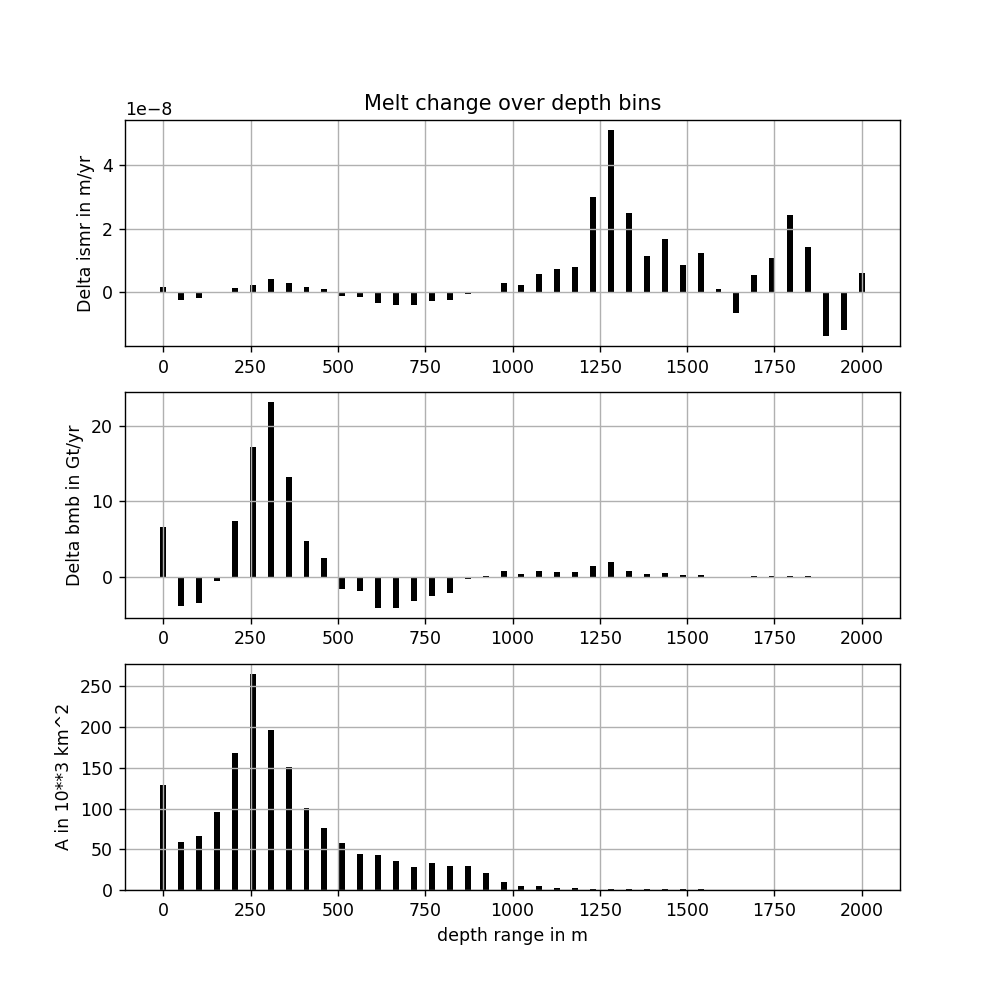

In [161]:
dm_db,dbmb_db,A_db = make_bins(-grd.zice,0,2000,40)
bar_bin(dm_db,dbmb_db,A_db,np.linspace(0,2000,40),'Melt change over depth bins','depth range in m',save=True)

<IPython.core.display.Javascript object>


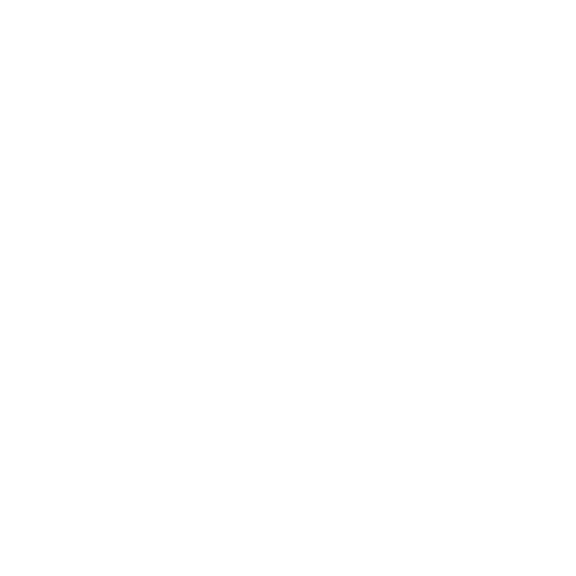

In [366]:
dm_sb,dbmb_sb,A_sb = make_bins(grd.gradZice,0,0.10,40)
bar_bin(dm_sb,dbmb_sb,A_sb,np.linspace(0,0.10,40),'Melt change over slope bins','slope range in m/m',save=True)

## normalized depth

In [94]:
for k,v in log_progress(shelves.items(),every=2):
    mask = v['mask']
    zmin,zmax = (grd.zice.where(mask).min(),grd.zice.where(mask).max())
    shelves[k]['nzice'] = (grd.zice.where(mask) - zmax)/(zmin-zmax)

In [117]:
nzice = np.zeros_like(grd.mask_rho)
nzice[:,:] = np.nan
for k,v in shelves.items():
    ii = v['nzice'].isnull()
    nzice[~ii]=v['nzice'].values[~ii]
grd['nzice'] = xr.DataArray(nzice,dims=('eta_rho','xi_rho'))

<IPython.core.display.Javascript object>


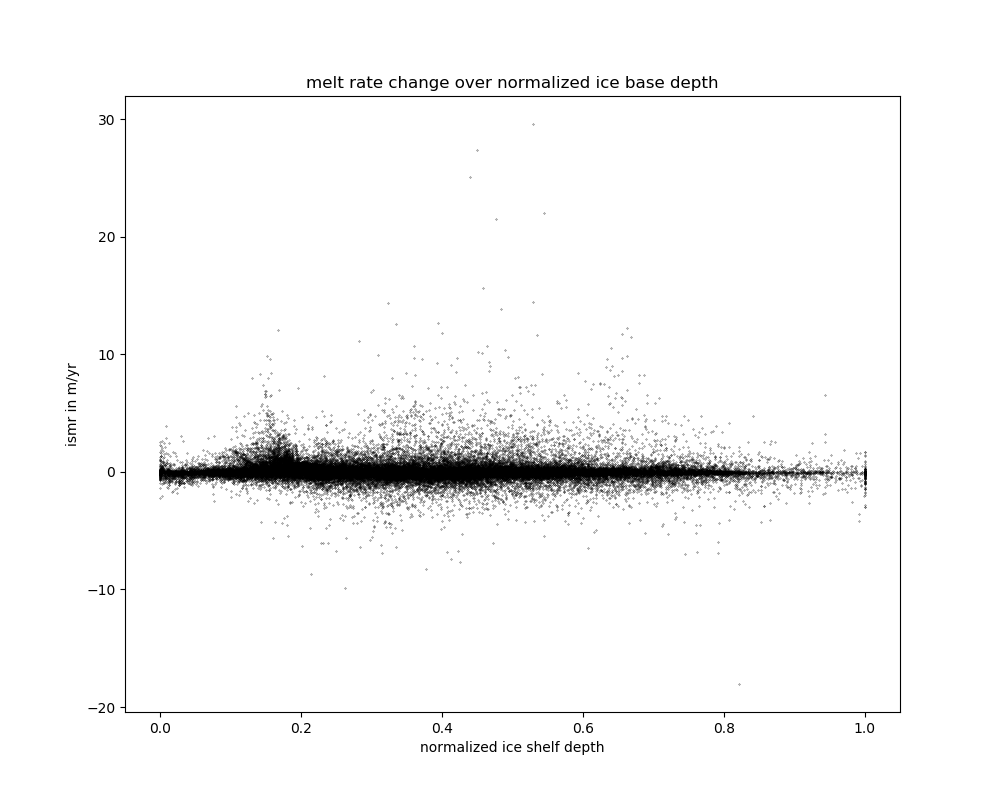

In [130]:
scatter(grd.nzice,'normalized ice shelf depth','melt rate change over normalized ice base depth',
        mask=~grd.nzice.isnull())

<IPython.core.display.Javascript object>


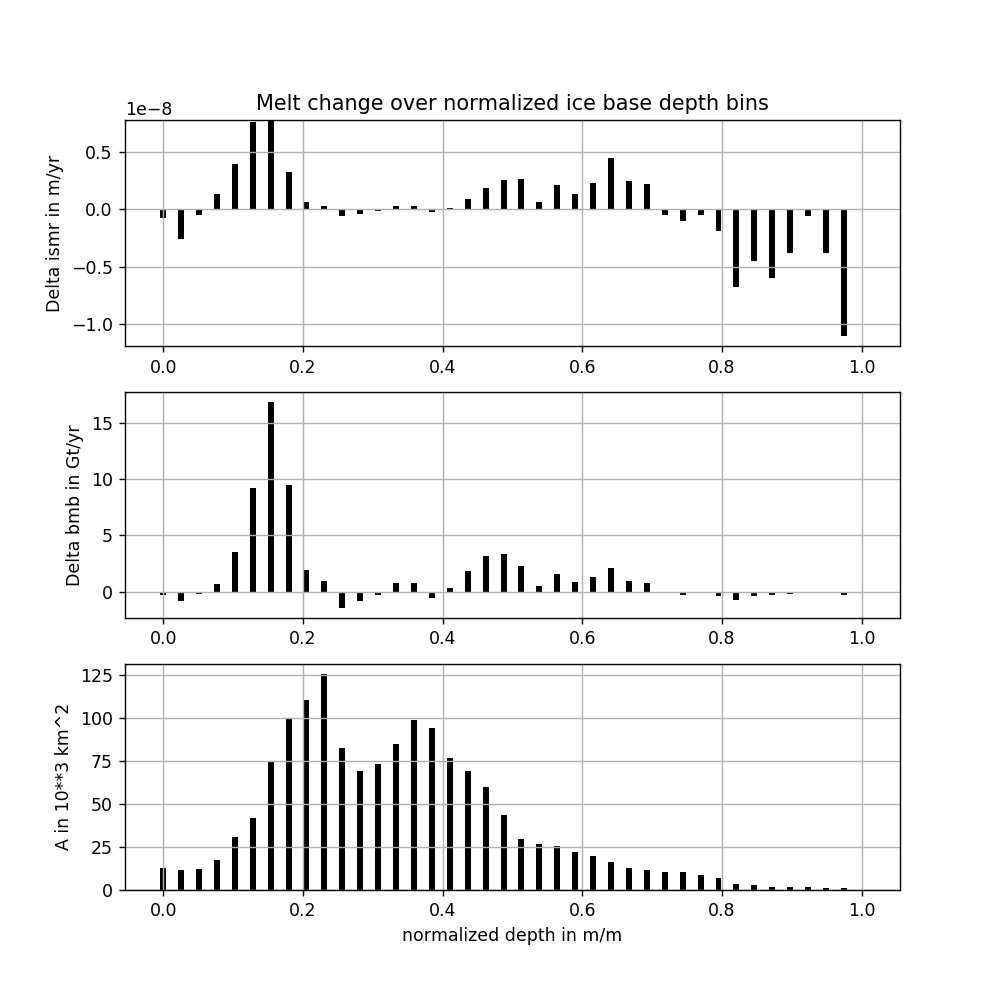

In [167]:
dmb,dbmbb,Ab = make_bins(grd.nzice,0,1,40,mask=~grd.nzice.isnull())
bar_bin(dmb,dbmbb,Ab,np.linspace(0,1,40),'Melt change over normalized ice base depth bins','normalized depth in m/m',save=True)

## Mean velocity change (tidal residual, ice pump, etc)

In [164]:
def make_rho_velo(ubar,vbar,grd):
    ubar_rho,vbar_rho = rotate_vector_roms(ubar.values,vbar.values,np.zeros_like(grd.mask_rho))
    velo_mag = np.sqrt(ubar_rho**2 + vbar_rho**2)
    
    return xr.DataArray(velo_mag,dims=grd.mask_rho.dims,name='velocity magnitude')

In [165]:
tides_velo = make_rho_velo(tides.ubar.squeeze(),tides.vbar.squeeze(),grd)
no_tides_velo = make_rho_velo(no_tides.ubar.squeeze(),no_tides.vbar.squeeze(),grd)

<IPython.core.display.Javascript object>


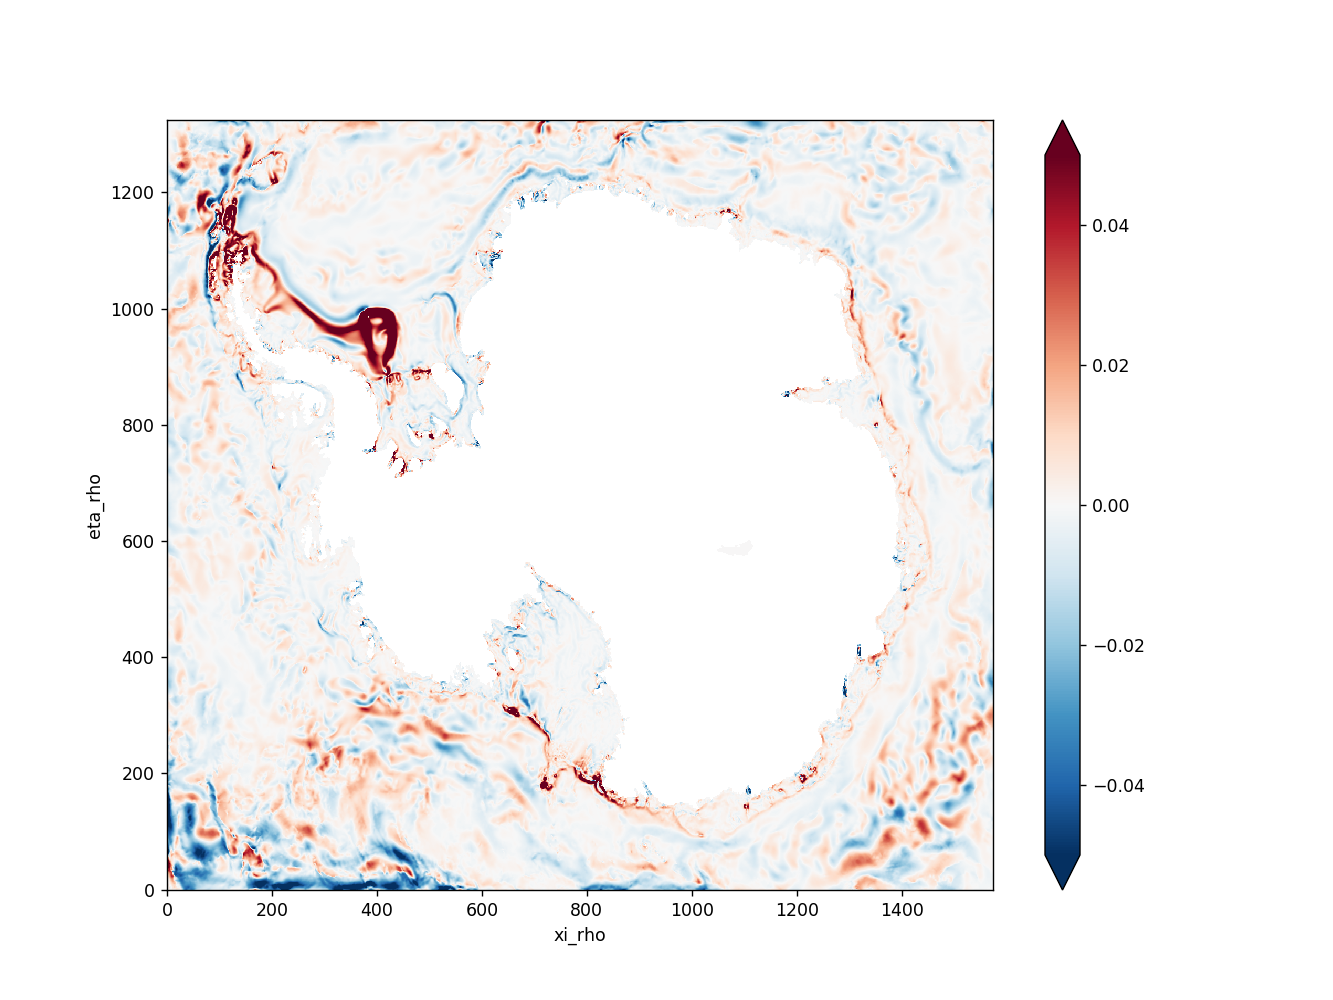

In [166]:
mask_is = (grd.mask_rho==1)
plt.close()
(tides_velo-no_tides_velo).where(mask_is).plot(size=8,vmax=0.05)

<IPython.core.display.Javascript object>


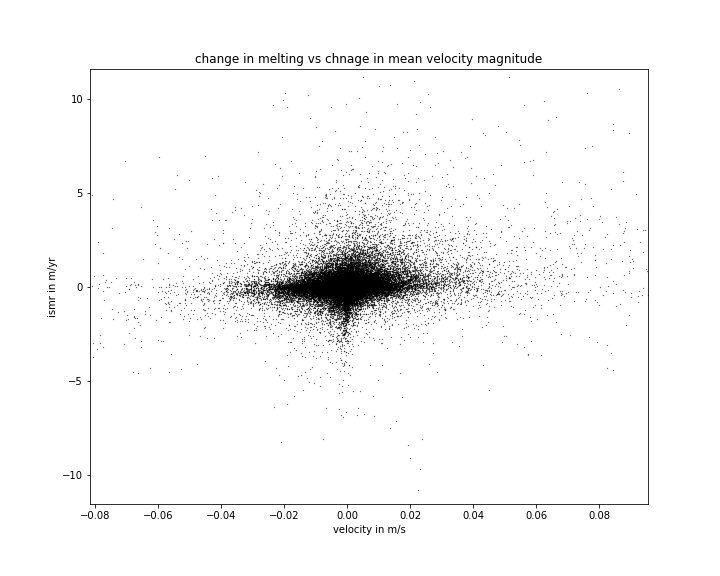

In [348]:
scatter(tides_velo-no_tides_velo,'velocity in m/s','change in melting vs chnage in mean velocity magnitude')

<IPython.core.display.Javascript object>


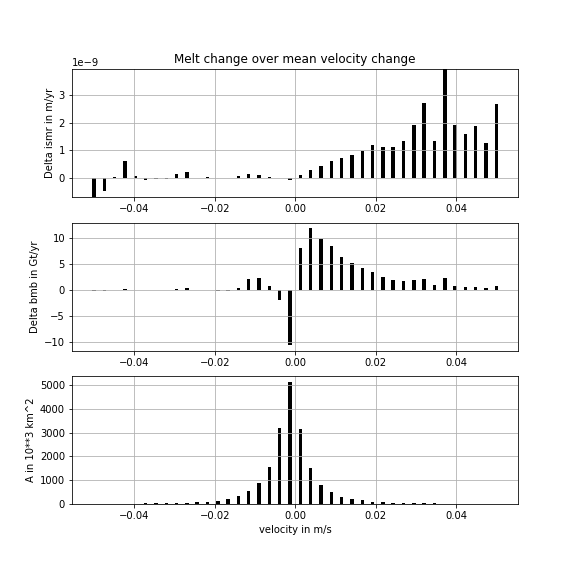

In [367]:
dm_vb,dbmb_vb,A_vb = make_bins(tides_velo-no_tides_velo,-0.05,0.05,40)
bar_bin(dm_vb,dbmb_vb,A_vb,np.linspace(-0.05,0.05,40),'Melt change over mean velocity change','velocity in m/s',save=True)

## Tidal oscillating current

In [4]:
file_path = os.path.join(data_dir,'raw','waom4','ocean_his_hr_0010.nc')
tides_hr = xr.open_dataset(file_path)

file_path = os.path.join(data_dir,'raw','waom4_nt','ocean_his_hr_0010.nc')
no_tides_hr = xr.open_dataset(file_path)

In [5]:
tidal_velo = xr.open_dataarray(os.path.join(int_dir,'tidal_velo4.nc'))

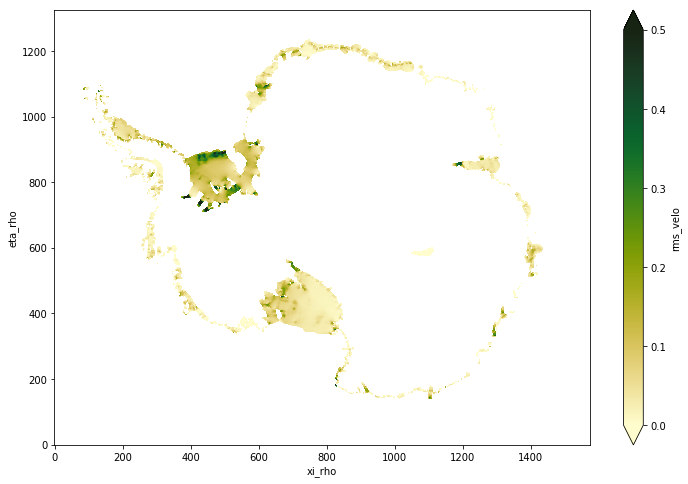

In [6]:
plt.close()
(tidal_velo).plot(size=8,cmap=ocm.speed,vmin=0,vmax=0.5)

In [9]:
%matplotlib notebook
scatter(tidal_velo,'velocity in m/s','melt rate change over tidal velocity (rms)')

NameError: name 'scatter' is not defined

<IPython.core.display.Javascript object>


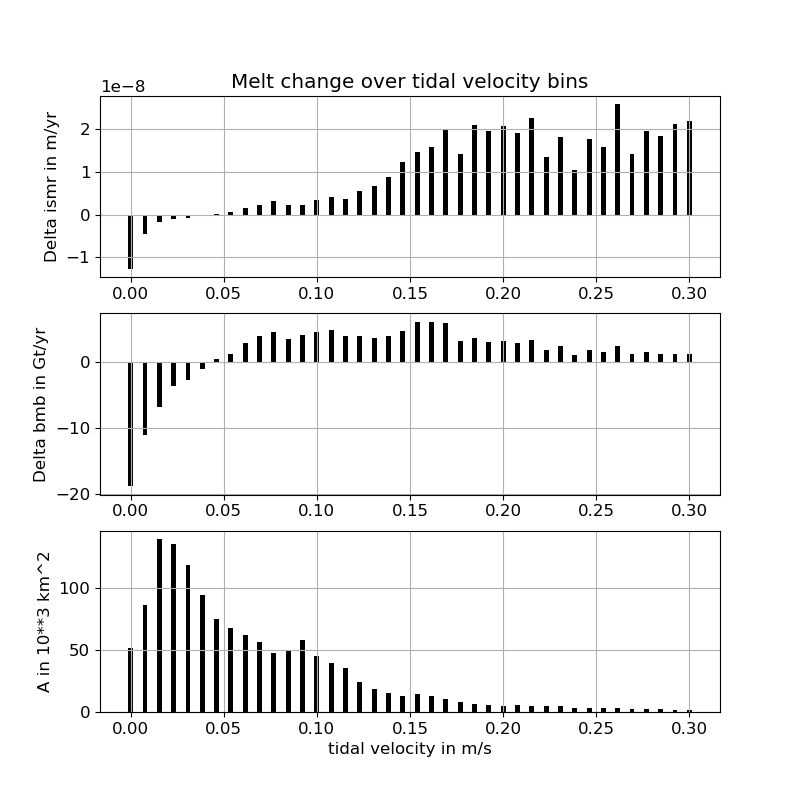

In [77]:
dmb,dbmbb,Ab = make_bins(tidal_velo,0,0.3,40)
bar_bin(dmb,dbmbb,Ab,np.linspace(0,0.3,40),'Melt change over tidal velocity bins','tidal velocity in m/s',save=True)

# ustar Tstar relation changes

In [40]:
from tools.calc_melt_frc import calc_ustar,calc_frc,calc_insituTemp
tidal_velo = xr.open_dataarray(os.path.join(int_dir,'tidal_velo4.nc'))

mask = ((grd.zice<0) & (grd.mask_rho==1))
m = tides.m.where(mask).squeeze()
Sm = tides.salt.isel(s_rho=30).where(mask).squeeze()
Tpot = tides.temp.isel(s_rho=30).where(mask).squeeze()
zice = grd.zice.where(mask)

#Tm = calc_insituTemp(mask,Tpot,Sm,zice)
#Tm.to_netcdf(os.path.join(int_dir,'situTemp.nc'))
Tm = xr.open_dataarray(os.path.join(int_dir,'situTemp4.nc')).where(mask)

u = tides.u
v = tides.v
ustar = calc_ustar(u,v,mask)
ustar_t = calc_ustar(u,v,mask) + (tidal_velo*np.sqrt(5.0e-3))
Tfr,Sfr,Tdr = calc_frc(Tm,Sm,zice,ustar,grd.f.where(mask),m,mask)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [41]:
m_nt = no_tides.m.where(mask).squeeze()
Sm_nt = no_tides.salt.isel(s_rho=30).where(mask).squeeze()
Tpot_nt = no_tides.temp.isel(s_rho=30).where(mask).squeeze()

#Tm_nt = calc_insituTemp(mask,Tpot_nt,Sm_nt,zice)
#Tm_nt.to_netcdf(os.path.join(int_dir,'situTemp4nt.nc'))
Tm_nt = xr.open_dataarray(os.path.join(int_dir,'situTemp4_nt.nc')).where(mask)

u_nt = no_tides.u
v_nt = no_tides.v
ustar_nt = calc_ustar(u_nt,v_nt,mask)
Tfr_nt,Sfr_nt,Tdr_nt = calc_frc(Tm_nt,Sm_nt,zice,ustar_nt,grd.f.where(mask),m_nt,mask)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [44]:
from visualization.scatter_shelves_avg import find_sector, make_shelves_avg,polyfit
shelves = np.load(os.path.join(int_dir,'shelves4.npy')).item()

shelves = {k:v for k,v in shelves.items() if ustar.where(v['mask']).sum()!=0.0} 

for da,name in zip([m,Tdr,ustar,Tfr,Sfr,Tdr*ustar,Tfr*ustar],
                   ['ismr','Tdr','ustar','Tfr','Sfr','Tdr*ustar','Tfr*ustar']):
    print('processing '+name)
    shelves = make_shelves_avg(da,shelves,name)
    
shelves = {k:v for k,v in shelves.items() if np.isnan(v['ustar'])==False}

processing ismr


KeyboardInterrupt: 

distributed.scheduler - ERROR - Error transitioning "('where-mean_chunk-3311bb845e01497c794daf53d15c2172', 4, 6)" from 'erred' to 'released'
Traceback (most recent call last):
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/scheduler.py", line 3724, in transition
    % (start, finish))
RuntimeError: Impossible transition from 'erred' to 'released'
distributed.utils - ERROR - Impossible transition from 'erred' to 'released'
Traceback (most recent call last):
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/scheduler.py", line 1657, in remove_worker
    self.transitions(recommendations)
  File "/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/scheduler.py", line 3769, in transitions
    new

In [45]:
for da,name in zip([m,Tfr,ustar_t,Tfr*ustar_t],
                   ['ismr','Tfr','ustar_t','Tfr*ustar_t']):
    print('processing '+name)
    shelves = make_shelves_avg(da,shelves,name)
    
shelves = {k:v for k,v in shelves.items() if np.isnan(v['ustar_t'])==False}

processing ismr


processing Tfr


processing ustar_t


processing Tfr*ustar_t


In [ ]:
for da,name in zip([m_nt,Tdr_nt,ustar_nt,Tfr_nt,Sfr_nt,Tdr_nt*ustar_nt,Tfr*ustar_nt],
                   ['ismr_nt','Tdr_nt','ustar_nt','Tfr_nt','Sfr_nt','Tdr*ustar_nt','Tfr*ustar_nt']):
    print('processing '+name)
    shelves = make_shelves_avg(da,shelves,name)

In [ ]:
for x_name in ['Tfr*ustar_nt','Tfr*ustar']:
    scatter_shelves_avg(x_name,'ismr','ismr over '+x_name,x_name,'ismr in m/s',sector_dict=sector)

In [ ]:
import matplotlib
def scatter_tides(x_quant,y_quant,title,xlab,ylab,shelves_dict=shelves,save=False,big=False):
    
    matplotlib.rcParams.update({'font.size': 18})
    
    plt.close()
    fig,ax = plt.subplots(figsize=(12,10))
    
    x_ar={}
    y_ar={}
    
    for t,c,pos in zip(['_nt',''],['r','g'],[0.9,0.8]):
        
        x_all=[]
        y_all=[]

        for key,data in shelves_dict.items():
            
            if big:
                if data['A']<5: continue

        
            if t == '_nt':
                x_ar[key]=[]
                y_ar[key]=[]
        
            x=shelves_dict[key][x_quant+t]
            y=shelves_dict[key][y_quant+t]
                   
            ax.plot(x,y,'.',label=key,c=c)
            #if res == '2':
            #    ax.annotate(key,(x,y),size='x-small')

            x_ar[key].append(x)
            y_ar[key].append(y)
        
            x_all.append(x)
            y_all.append(y)
            
        x_all = np.array(x_all).squeeze()
        y_all = np.array(y_all).squeeze()
    
        xp,p,Rsquared = polyfit(x_all,y_all,2)        
        ax.plot(xp,p(xp),'-',label='constrained poly fit',alpha=0.3,c=c)
        if t=='':
            label='4km with tides:'
        else:
            label='4km without tides:'
            
        ax.text(0.01,pos,label+str(p)+' ($r^2$ = %.2f)' %(Rsquared),transform=ax.transAxes,
                fontsize=16,color=c)       

        #xp,p,Rsquared = polyfit(x_all,y_all,1)        
        #ax.plot(xp,p(xp),'-',label='constrained poly fit',alpha=0.3,c=c)
        #ax.text(0.1,pos-0.05,str(p)+'\n ($r^2$ = %.2f)' %(Rsquared),transform=ax.transAxes,
        #        fontsize=12,color=c,alpha=0.3)      
    
    for key in x_ar:
        ax.annotate("", xy=(x_ar[key][1],y_ar[key][1]), xytext=(x_ar[key][0],y_ar[key][0]),
                    arrowprops=dict(arrowstyle="->",color='k',alpha=0.3))
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title,fontsize=18)
    
    if save:
        plt.savefig(os.path.join(fig_dir,'scatter_shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=300,bbox_inches = "tight")    
    plt.show()

In [ ]:
for x_name,xlab in zip(['ustar','Tdr','Tfr','Sfr','Tdr*ustar','Tfr*ustar'],
                       ['m/s','degC','degC','degC','degC*m/s','degC*m/s']):
    scatter_tides(x_name,'ismr','ismr over '+x_name,x_name+' in '+xlab,'ismr in m/s')

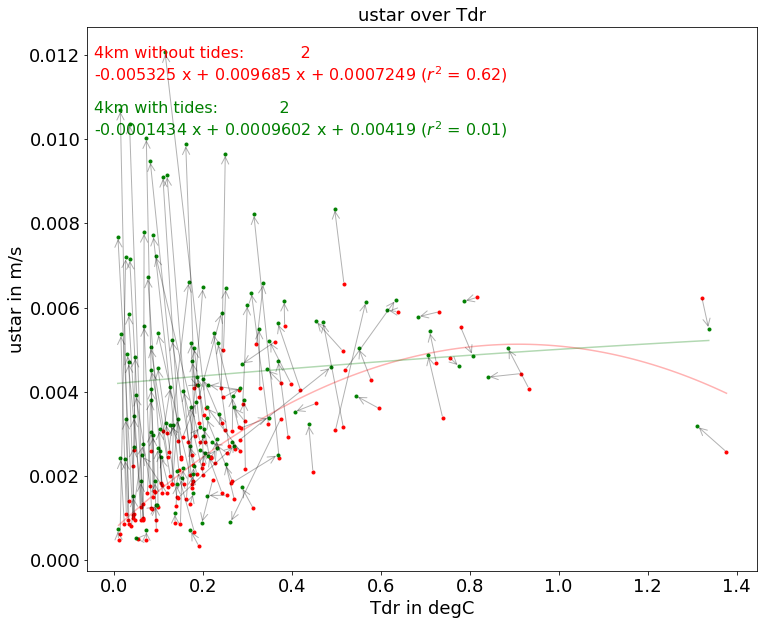

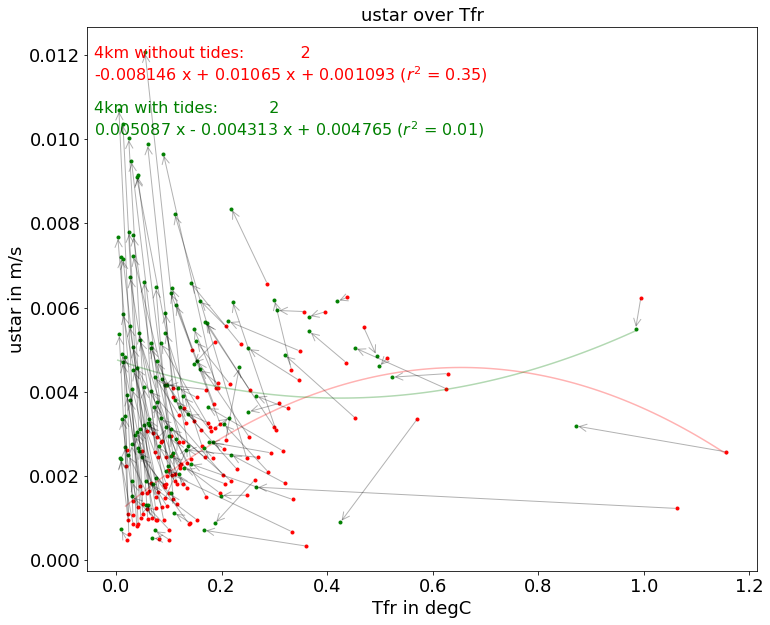

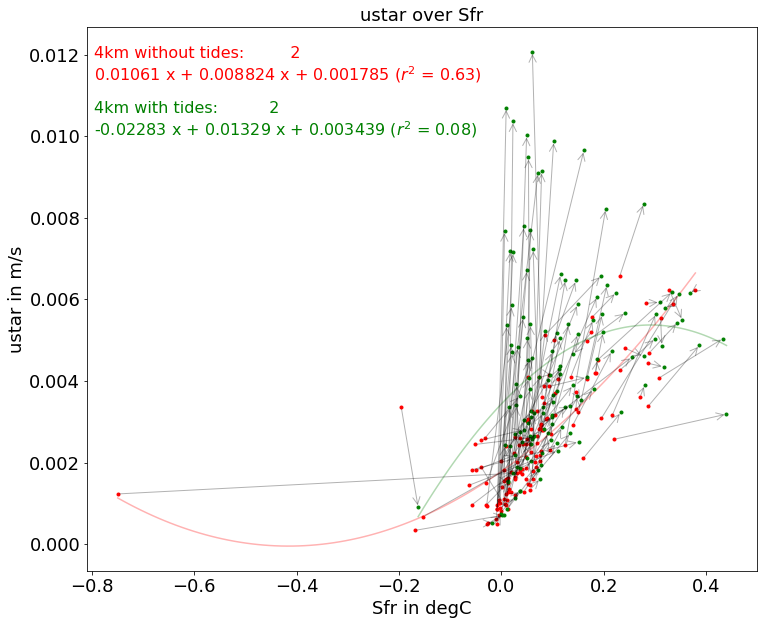

In [17]:
for x_name,xlab in zip(['Tdr','Tfr','Sfr'],
                       ['degC','degC','degC']):
    scatter_tides(x_name,'ustar','ustar over '+x_name,x_name+' in '+xlab,'ustar in m/s')

In [46]:
%matplotlib inline
import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

def BIC_AIC_test(data):
    n_components = np.arange(1, 21)
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(data)
              for n in n_components]
    plt.figure(figsize=(10,6))
    plt.plot(n_components, [m.bic(data) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(data) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components');
    
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    fig,ax = plt.subplots()
    
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    #ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor,ax=ax)
    
    ax.set_xlim([min(x)-0.5*np.std(x),max(x)+0.5*np.std(x)])
    ax.set_ylim([min(y)-0.5*np.std(y),max(y)+0.5*np.std(y)])
    
    plt.show()

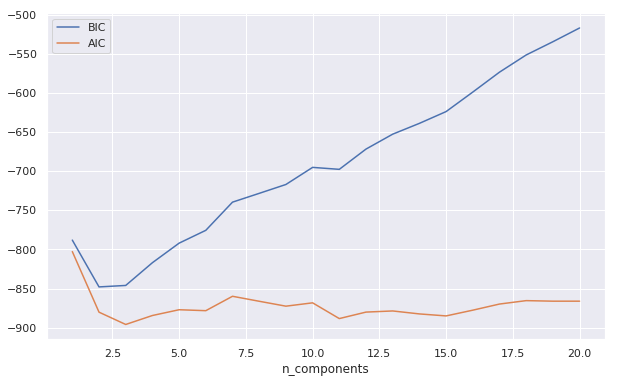

In [47]:
k = np.array([k for k,v in shelves.items()]).squeeze()
y = np.sqrt(np.array([v['ustar_t'] for k,v in shelves.items()]).squeeze())
x = np.array([v['Tfr'] for k,v in shelves.items()]).squeeze()

data = np.vstack([x, y]).T

BIC_AIC_test(data)

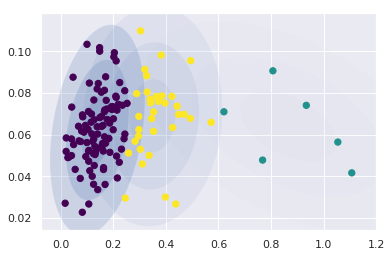

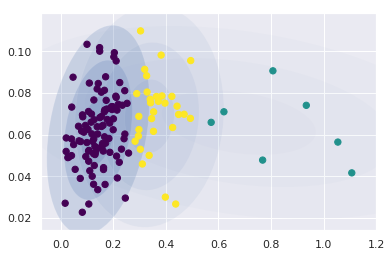

In [48]:
model1 = GaussianMixture(n_components=3,covariance_type='full').fit(data)
model2 = BayesianGaussianMixture(n_components=16,covariance_type='full').fit(data)

plot_gmm(model1,data)
plot_gmm(model2,data)

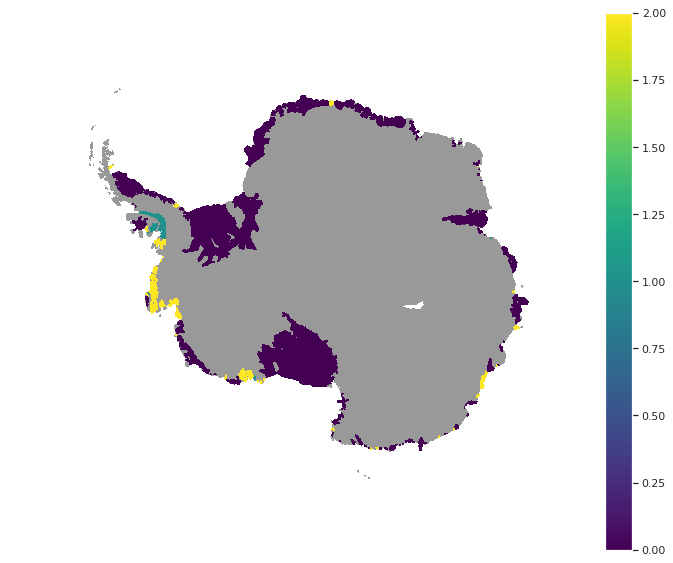

In [52]:
for i,key in enumerate(k):
    shelves[key]['BGM'] = model1.predict(data)[i]
    
shelf_map = np.zeros_like(grd.mask_rho)
shelf_map[:] = np.nan

for key,values in log_progress(shelves.items(),every=2):
    avg = values['BGM']
    shelf_map[values['mask']]=avg
shelf_map =  xr.DataArray(shelf_map,dims=('eta_rho','xi_rho')).where((grd.zice<0)&(grd.mask_rho==1))

plt.close()
fig,ax = plt.subplots(figsize=(10,8))
ax.axis('off')
ax.set_aspect('equal')
ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
plot = shelf_map.plot(ax=ax)
#ax.set_ylim([250,2500])
#ax.set_xlim([200,2900])
plt.tight_layout()
#plt.savefig(os.path.join(fig_dir,'tmp','map_'+title.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
plt.show()

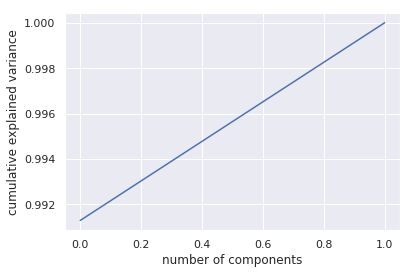

[0.99129682 0.00870318]


In [55]:
from sklearn.decomposition import PCA
%matplotlib inline
plt.close()
pca = PCA().fit(data)
plt.plot(np.arange(2),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
print(pca.explained_variance_ratio_)

principal components:  [[ 0.99991659  0.01291598]
 [-0.01291598  0.99991659]]
explained variance:  [0.03383093 0.00029702]


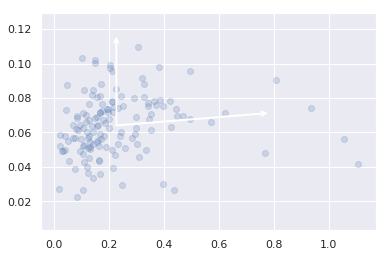

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)

print('principal components: ',pca.components_)
print('explained variance: ',pca.explained_variance_)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)

In [26]:
for k,v in log_progress(shelves.items(),name='ice shelf'):
    
    bmb,ismr,A = calc_mass_loss(tides.m,grd,v['mask'])
    
    shelves[k]['bmb'] = bmb
    shelves[k]['ismr'] = ismr
    shelves[k]['A'] = A
    
    bmb_nt,ismr_nt,A = calc_mass_loss(no_tides.m,grd,v['mask'])
    
    shelves[k]['bmb_nt'] = bmb_nt
    shelves[k]['ismr_nt'] = ismr_nt

In [28]:
sector = np.load(os.path.join(int_dir,'mask_sector_4.npy')).item()
shelves,sector=find_sector(shelves,sector)
np.save(shelves_path,shelves)

In [66]:
df_shelves = {}
for k,v in shelves.items():
    df_shelves[k] = {k:v for k,v in v.items() if k in ['bmb','A','ismr','lon_mid','bmb_nt','ismr_nt',
                                                      'ustar','Tdr','Tfr','Sfr','Tdr*ustar','Tfr*ustar',
                                                      'ustar_nt','Tdr_nt','Tfr_nt','Sfr_nt','Tdr*ustar_nt',
                                                       'Tfr*ustar_nt','sector','sector_color']}

import pandas as pd
df_shelves = pd.DataFrame.from_dict(df_shelves,orient='index').sort_values('lon_mid')

for key in ['bmb','A','ismr','lon_mid','bmb_nt','ismr_nt','ustar','Tdr','Tfr','Sfr','Tdr*ustar','Tfr*ustar',
            'ustar_nt','Tdr_nt','Tfr_nt','Sfr_nt','Tdr*ustar_nt','Tfr*ustar_nt']:
    df_shelves[key] = df_shelves[key].astype(float)

In [80]:
%matplotlib inline
def bar_shelves(quant,title,ylab,save=False):
    plt.close()
    fig,ax = plt.subplots(figsize=(24,6))
    quant.plot.bar(ax=ax,color=df_shelves.sector_color,fontsize=12)
    ax.grid()
    ax.set_ylabel(ylab)
    if save:
        plt.savefig(os.path.join(fig_dir,'bar_shelves_'+title.replace('/','_').replace(' ','_')+'.png'),
                    bbox_inches='tight')
    plt.show()

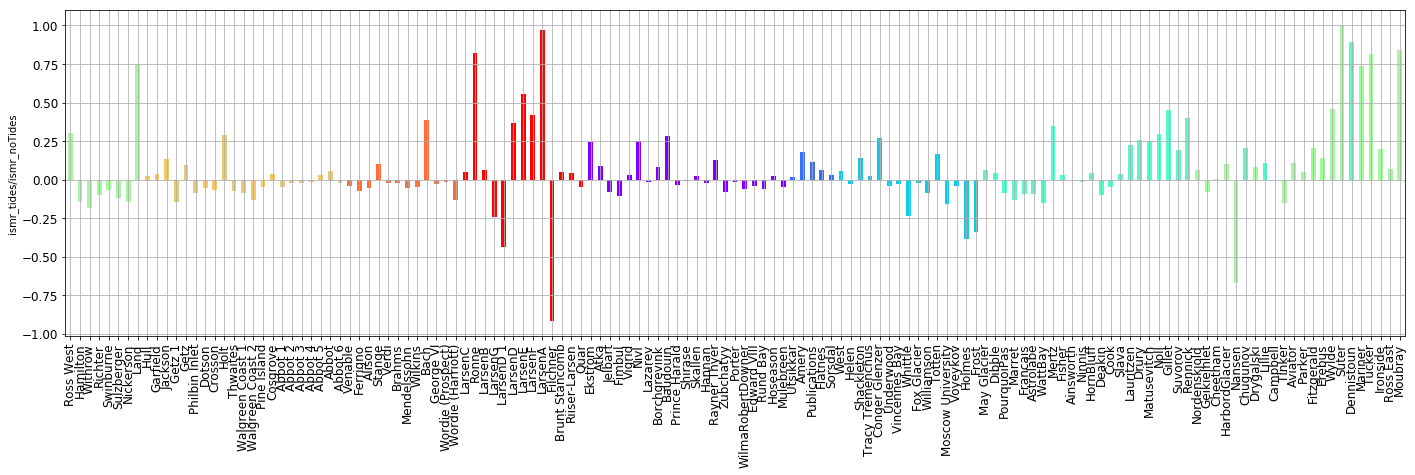

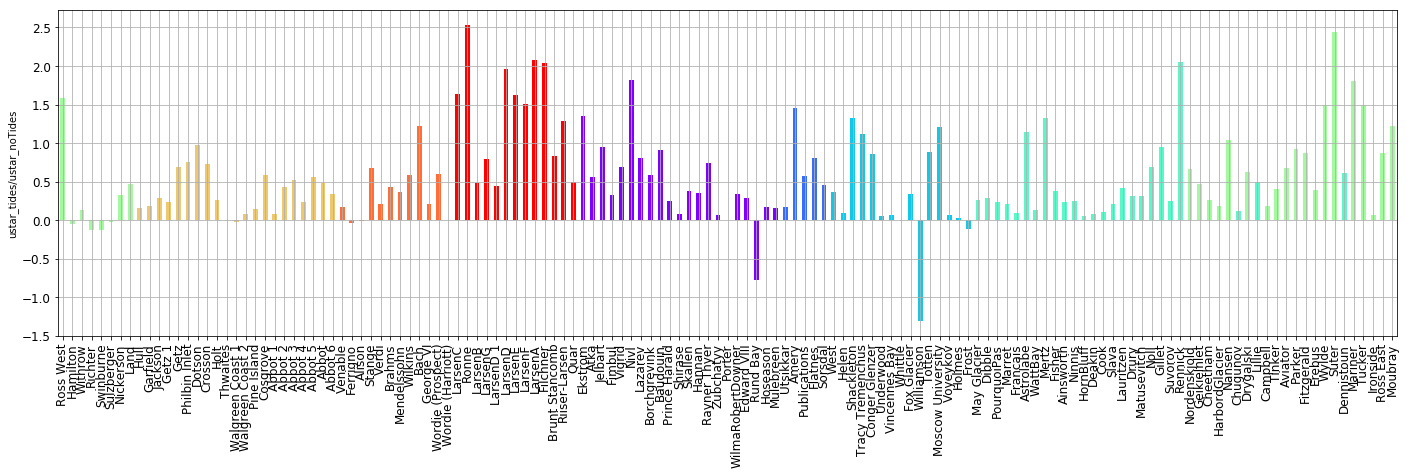

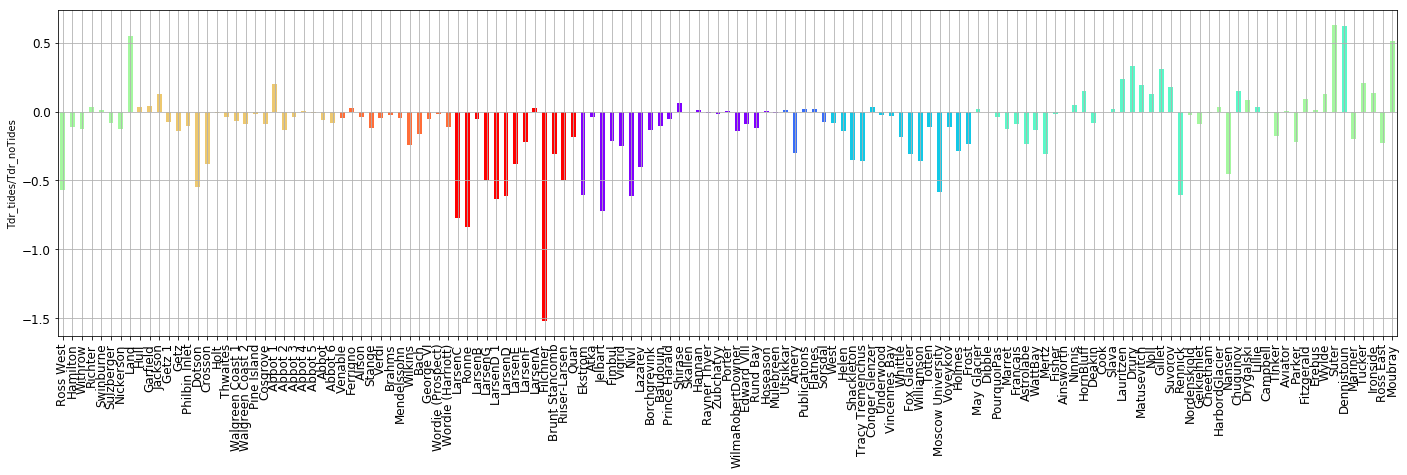

In [81]:
for key in ['ismr','ustar','Tdr']:
    bar_shelves(np.log(df_shelves[key]/df_shelves[key+'_nt']),key+' change',key+'_tides/'+key+'_noTides',save=True)

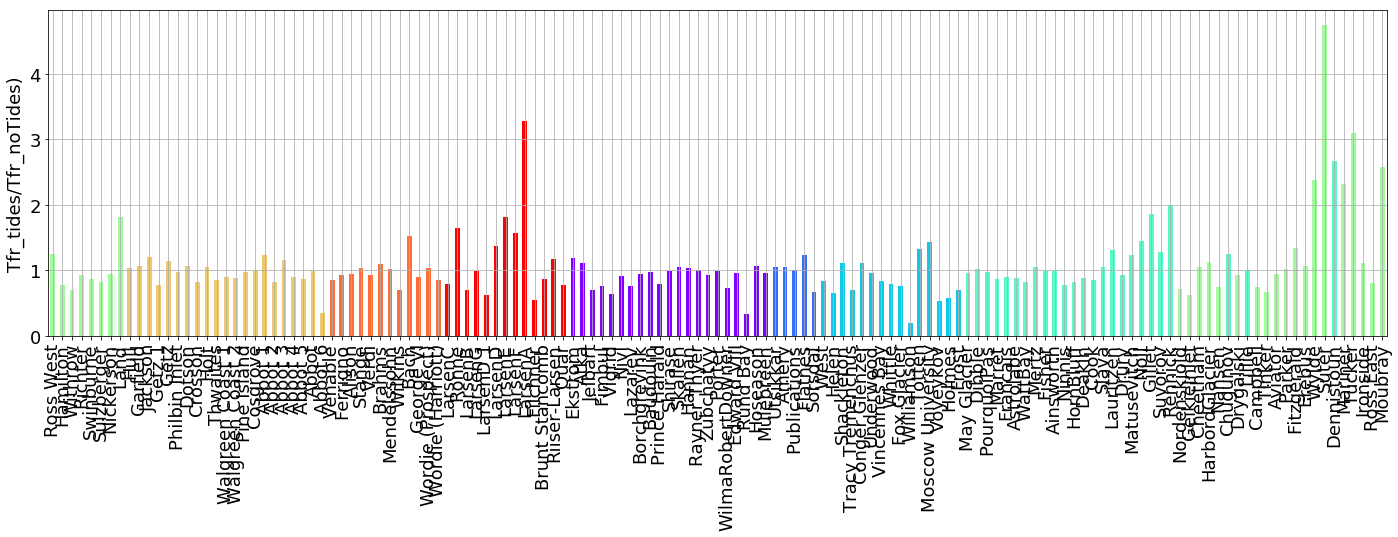

In [76]:
bar_shelves((df_shelves['Tfr*ustar']/df_shelves['Tfr*ustar_nt']),'Tfr*ustar change','Tfr_tides/Tfr_noTides)',save=True)

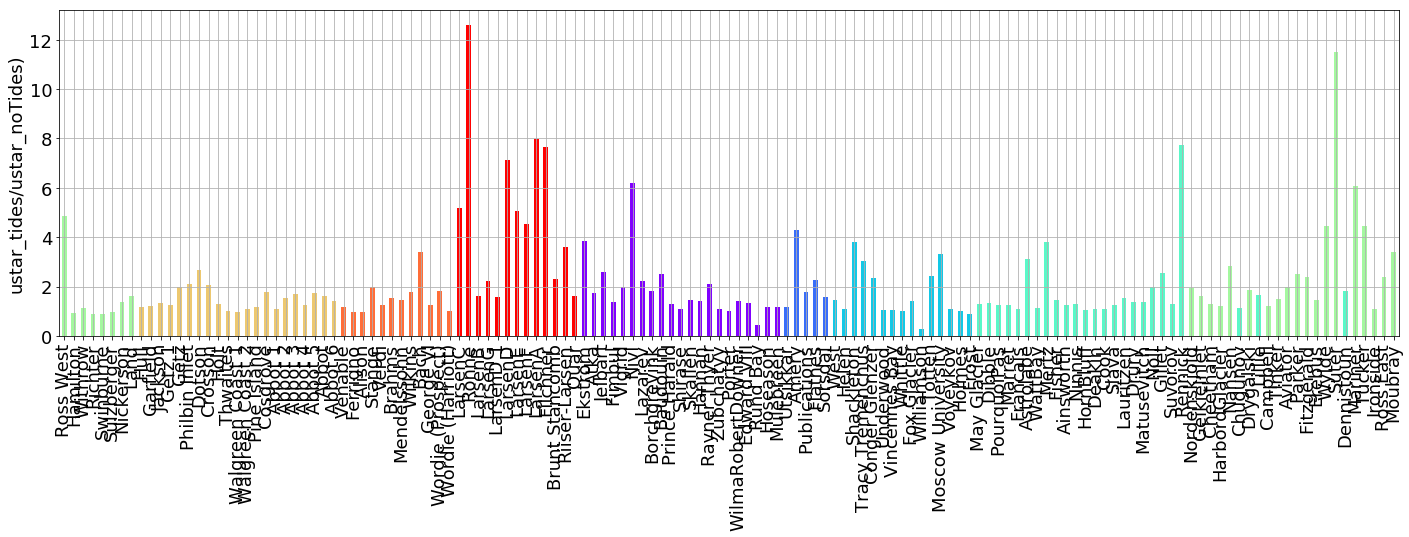

In [77]:
bar_shelves((df_shelves.ustar/df_shelves.ustar_nt),'ustar change','ustar_tides/ustar_noTides)',save=True)

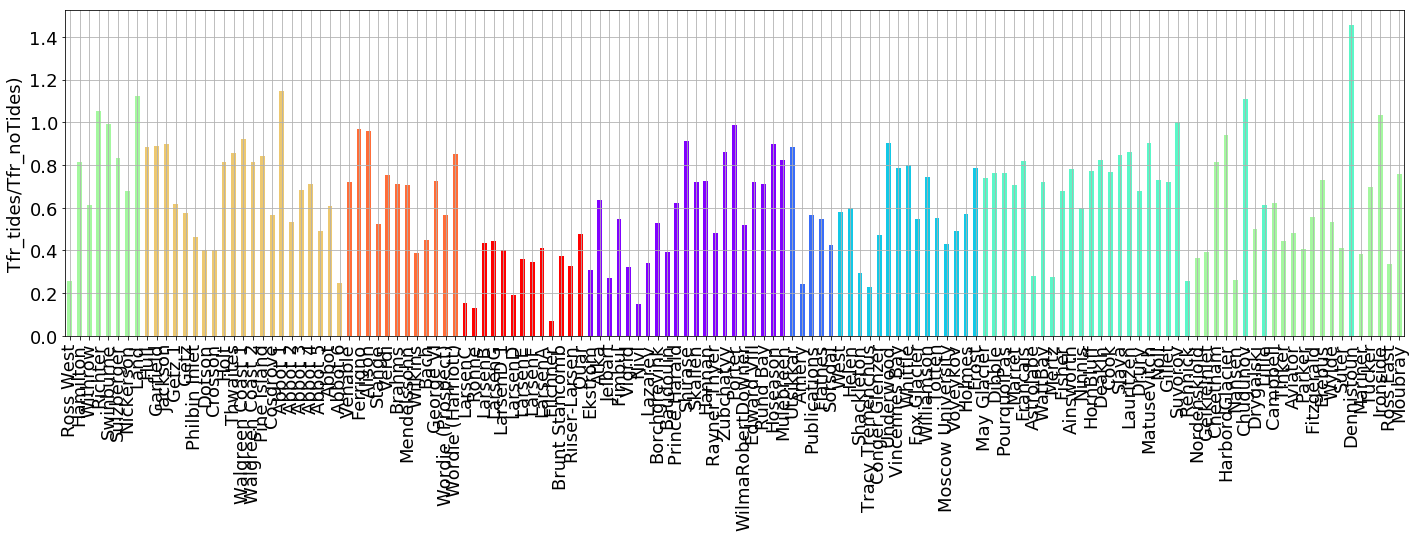

In [78]:
bar_shelves((df_shelves.Tfr/df_shelves.Tfr_nt),'Tfr change','Tfr_tides/Tfr_noTides)',save=True)

<IPython.core.display.Javascript object>


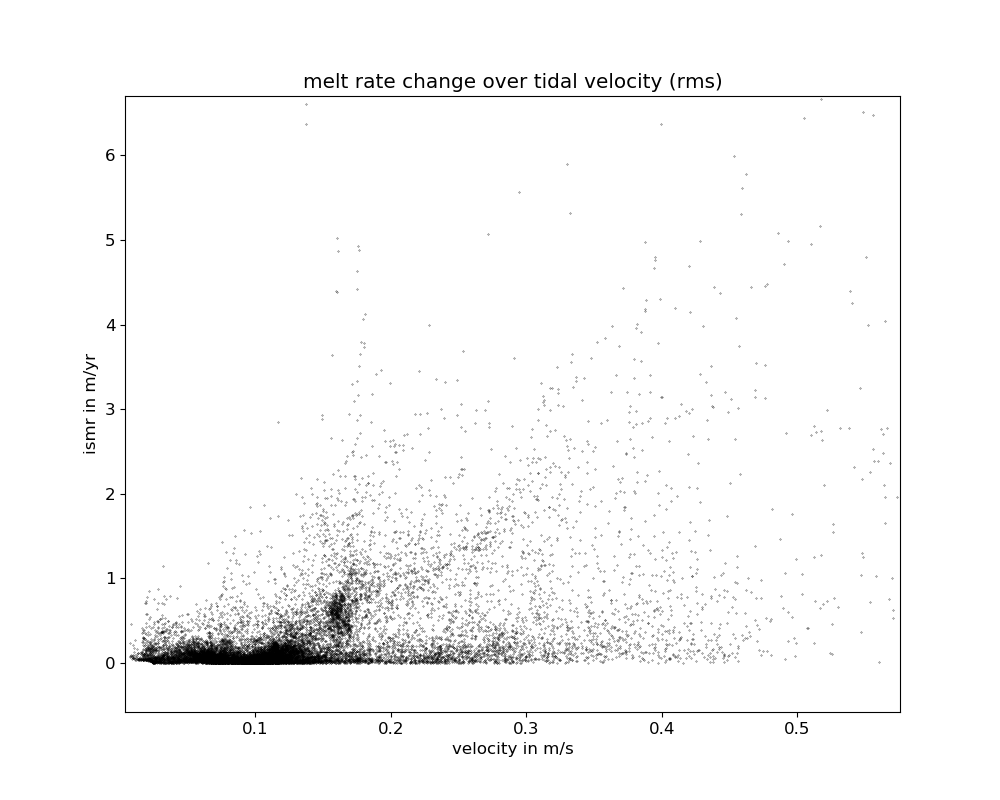

In [76]:
scatter_square(tidal_velo,'velocity in m/s','melt rate change over tidal velocity (rms)',mask=shelves['Ronne']['mask'])

In [ ]:
shelves,sector=find_sector(shelves,sector)

In [196]:
from tools.ustar import calc_ustar
from tools.melt_frc import calc_frc

Tm = xr.open_dataarray(os.path.join(data_dir,'analysis','interim','situTemp4.nc'))
Tm_nt = xr.open_dataarray(os.path.join(data_dir,'analysis','interim','situTemp4_nt.nc'))
Tm2 = xr.open_dataarray(os.path.join(data_dir,'analysis','interim','situTemp2.nc'))

In [49]:
mask = (grd.zice < 0.0)&(grd.mask_rho==1)

Sm_nt = no_tides.salt.isel(s_rho=30).where(mask) 
Sm = tides.salt.isel(s_rho=30).where(mask) 

ustar_nt = calc_ustar(no_tides.u,no_tides.v,mask)
ustar = calc_ustar(tides.u,tides.v,mask)

Tfr_nt,Sfr_nt,Tdr_nt = calc_frc(Tm_nt,Sm_nt,grd.zice,ustar_nt,grd.f,no_tides.m,mask)
Tfr,Sfr,Tdr = calc_frc(Tm,Sm,grd.zice,ustar,grd.f,tides.m,mask)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [219]:
mask2 = (grd2.zice < 0.0) & (grd2.mask_rho==1)
Sm2 = salt2.isel(s_rho=30).where(mask2).squeeze()
ustar2 = calc_ustar(u2.squeeze(),v2.squeeze(),mask2)
Tfr2,Sfr2,Tdr2 = calc_frc(Tm2.squeeze(),Sm2.squeeze(),grd2.zice,ustar2,grd2.f,m2.squeeze(),mask2)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [94]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22}) 

def plot_map(da,grd,title,cbar_label,cmap,vrange):
    plt.close()
    fig,ax = plt.subplots(figsize=(10,8))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=-2*std
        vmax=+2*std
    else:
        vmin,vmax=vrange
    da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label': cbar_label})
    ax.set_title(title)
    ax.set_ylim([250/2,2500/2])
    ax.set_xlim([200/2,2900/2])
    ax.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,'tmp','tidal_melting_'+title.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
    plt.show()

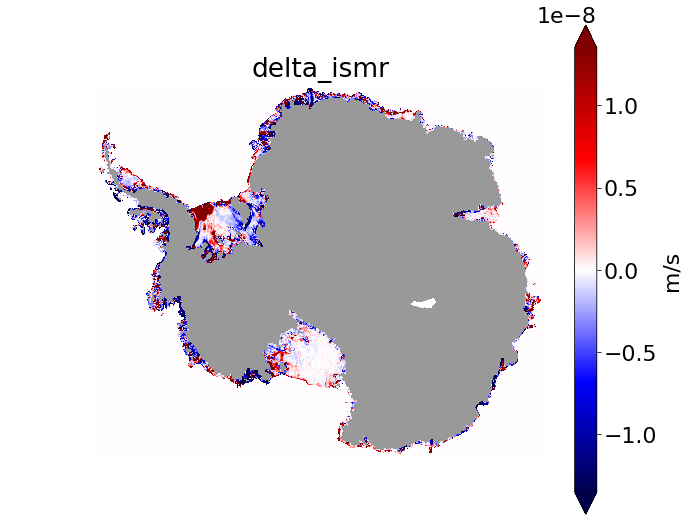

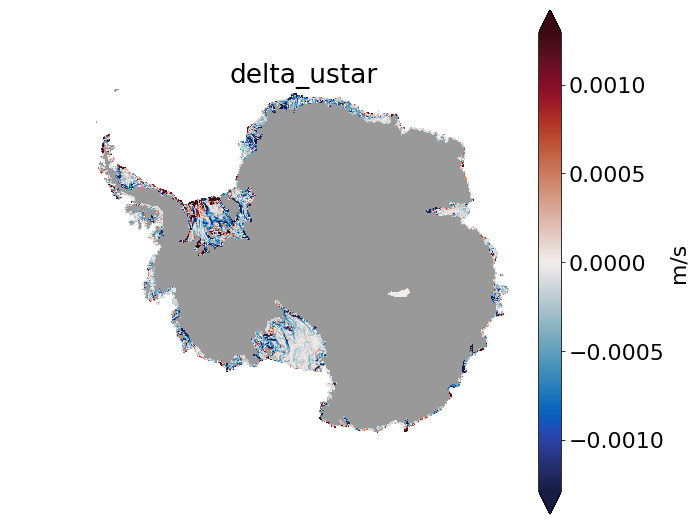

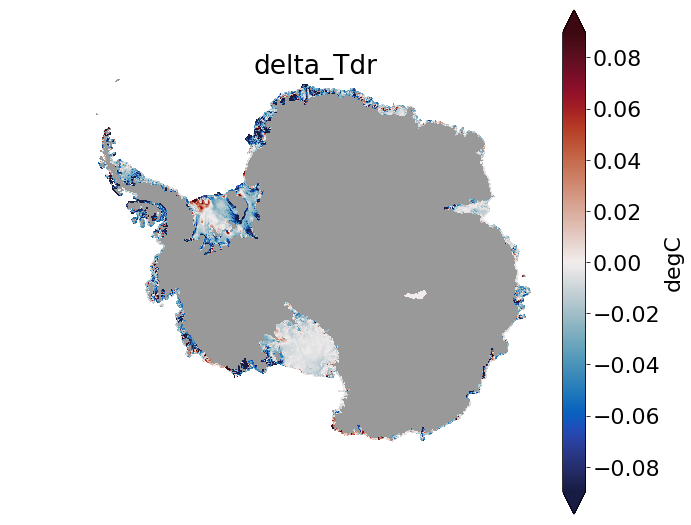

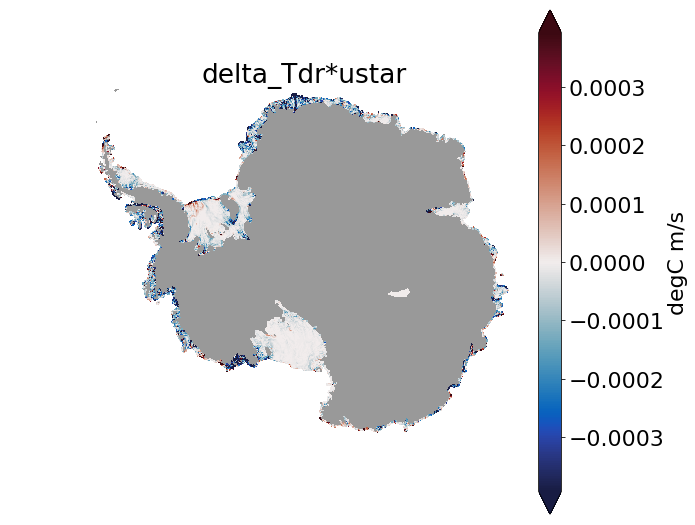

In [93]:
for da,title,cbt,cmap,vrange in zip([tides.m-no_tides.m,ustar-ustar_nt,Tdr-Tdr_nt,Tdr*ustar-Tdr_nt*ustar_nt],
                             ['delta_ismr','delta_ustar','delta_Tdr','delta_Tdr*ustar'],
                             ['m/s','m/s','degC','degC m/s'],
                             [plt.cm.seismic,ocm.balance,ocm.balance,ocm.balance],
                             [None,None,None,None]):
    plot_map(da,grd,title,cbt,cmap,vrange)

In [87]:
(Tdr_nt*ustar_nt).mean()*100

<xarray.DataArray ()>
array(0.034304)
Coordinates:
    s_rho       float64 -0.01613
    ocean_time  datetime64[ns] 2015-06-30T12:00:00

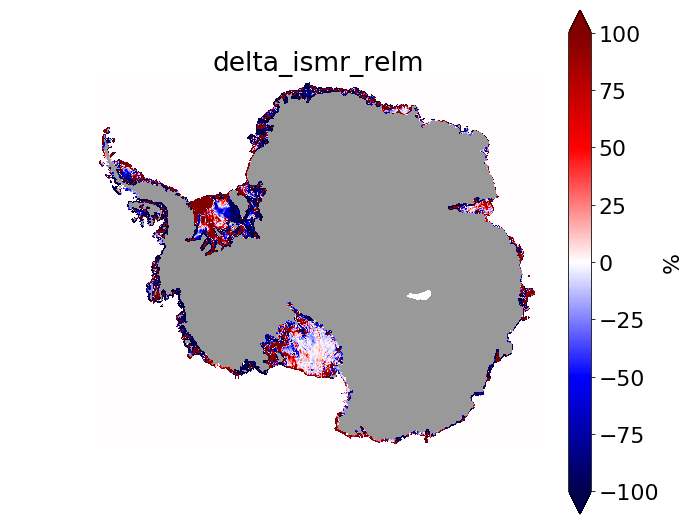

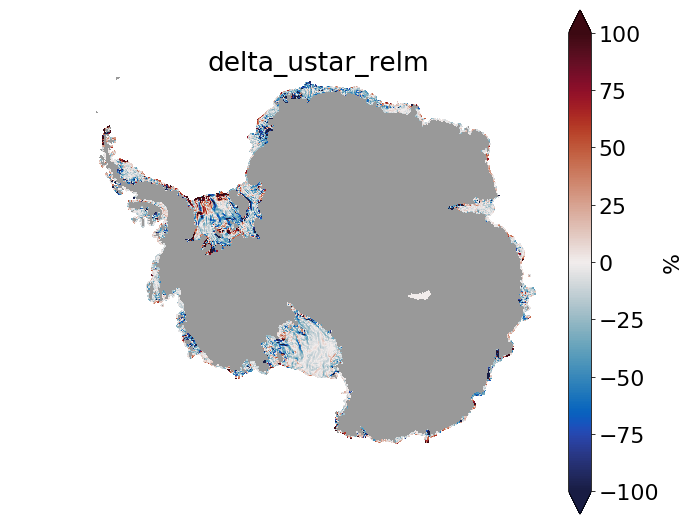

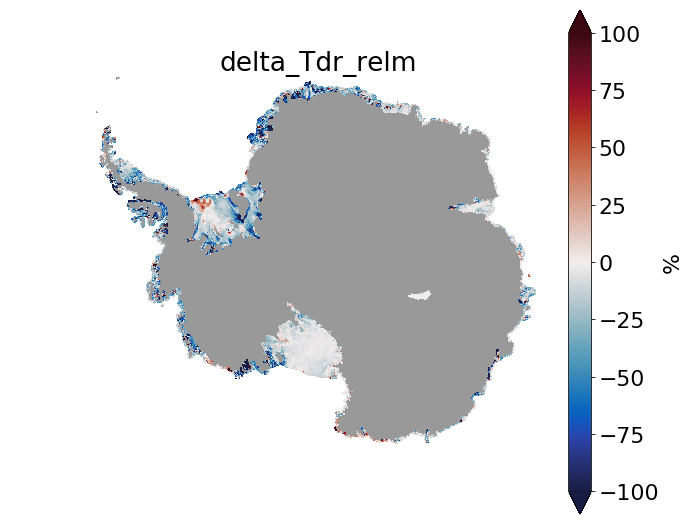

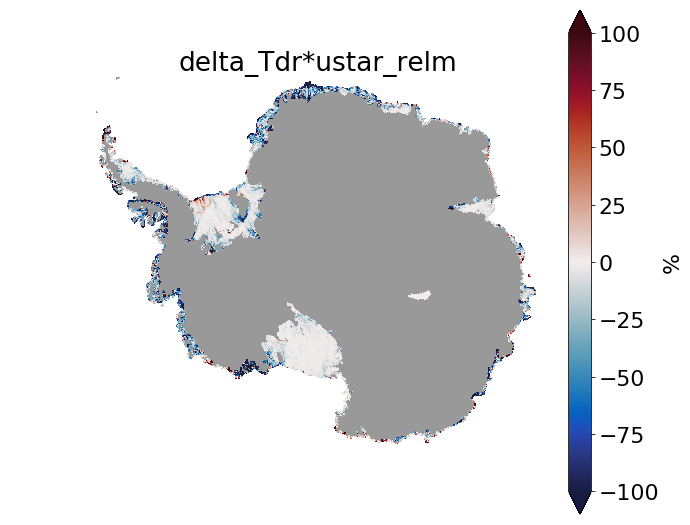

In [96]:
v_range=(-100,100)
for da,title,cbt,cmap,vrange in zip([(tides.m-no_tides.m)/no_tides.m.mean()*100,
                                     (ustar-ustar_nt)/ustar_nt.mean()*100,
                                     (Tdr-Tdr_nt)/Tdr_nt.mean()*100,
                                     (Tdr*ustar-Tdr_nt*ustar_nt)/(Tdr_nt*ustar_nt).mean()*100],
                             ['delta_ismr_relm','delta_ustar_relm','delta_Tdr_relm','delta_Tdr*ustar_relm'],
                             ['%','%','%','%'],
                             [plt.cm.seismic,ocm.balance,ocm.balance,ocm.balance],
                             [v_range,v_range,v_range,v_range]):
    plot_map(da,grd,title,cbt,cmap,vrange)

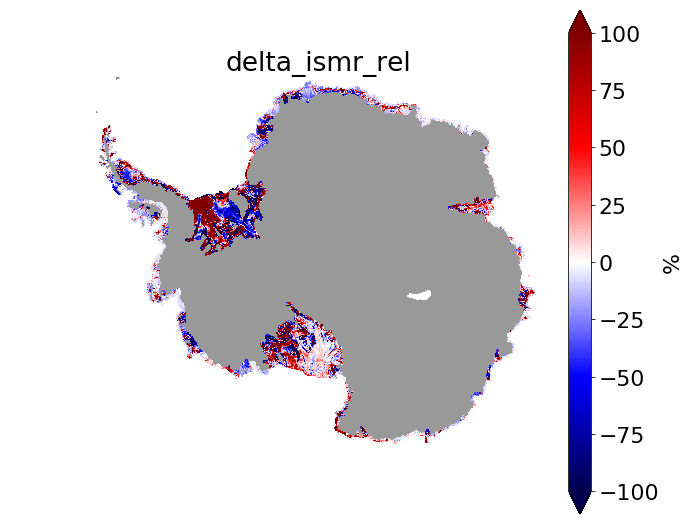

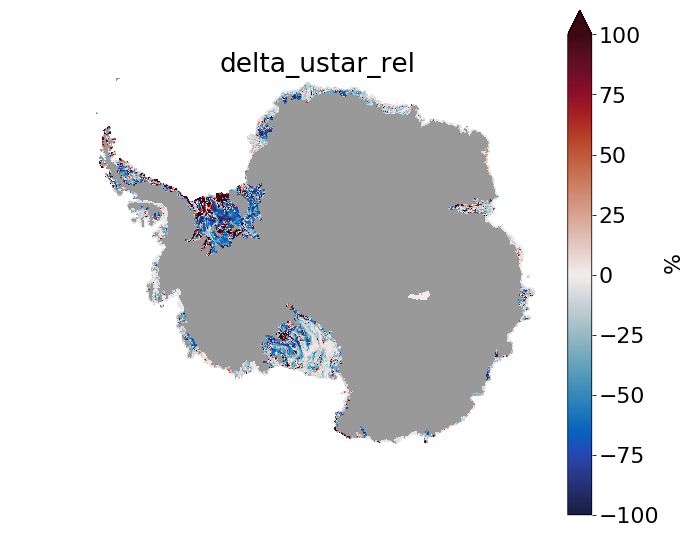

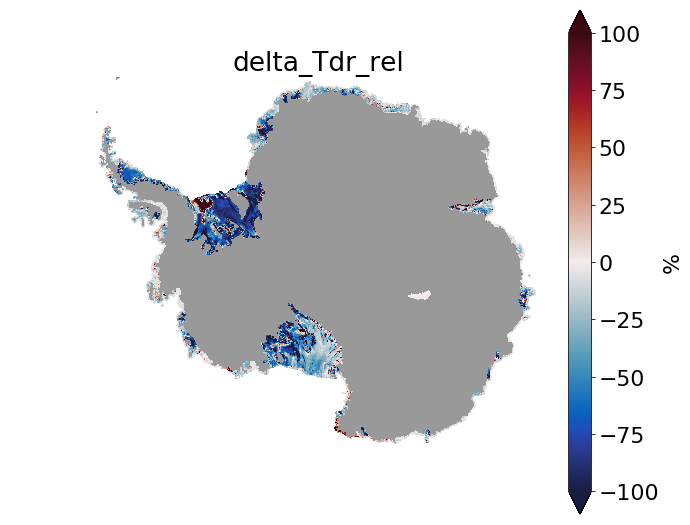

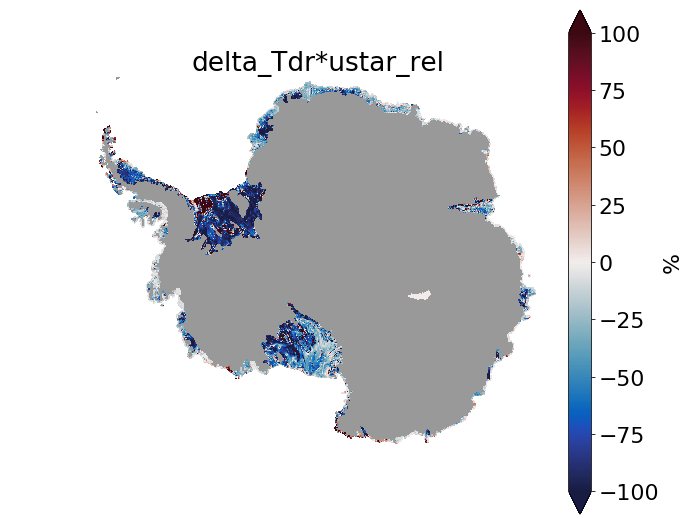

In [95]:
v_range=(-100,100)
for da,title,cbt,cmap,vrange in zip([(tides.m-no_tides.m)/no_tides.m*100,
                                     (ustar-ustar_nt)/ustar_nt*100,
                                     (Tdr-Tdr_nt)/Tdr_nt*100,
                                     (Tdr*ustar-Tdr_nt*ustar_nt)/(Tdr_nt*ustar_nt)*100],
                             ['delta_ismr_rel','delta_ustar_rel','delta_Tdr_rel','delta_Tdr*ustar_rel'],
                             ['%','%','%','%'],
                             [plt.cm.seismic,ocm.balance,ocm.balance,ocm.balance],
                             [v_range,v_range,v_range,v_range]):
    plot_map(da,grd,title,cbt,cmap,vrange)

In [99]:
shelves_path = os.path.join(proj_dir,'data','analysis','interim','shelves4.npy')
shelves = np.load(shelves_path).item()

In [225]:
def equip_shelves(shelves,grd):
    for k,v in log_progress(shelves.items(),every=2):
        dA = 1/(grd.pm.where(v['mask'])*grd.pn)
        shelves[k]['dA']=dA
        shelves[k]['weights']=dA/dA.sum()
        shelves[k]['A']=dA.sum().values*10**-9
    return shelves

distributed.nanny - WARNING - Worker process 3176 was killed by unknown signal
distributed.nanny - WARNING - Worker process 3178 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 3184 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 3187 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker


In [119]:
big_shelves = {k: v for k, v in shelves.items() if v['mask'].any() and shelves[k]["A"]>5}

In [224]:
big_shelves2 = {k: v for k, v in shelves2.items() if v['mask'].any() and v["A"]>5}

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 3117 was killed by unknown signal
distributed.nanny 

In [227]:
big_shelves2 = equip_shelves(big_shelves2,grd2)

<IPython.core.display.Javascript object>


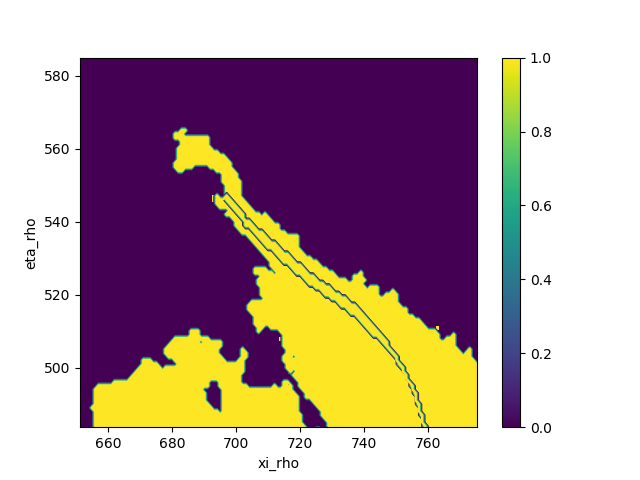

In [114]:
%matplotlib notebook
plt.close()
fig,ax = plt.subplots()
mask.plot()
for key,data in log_progress(big_shelves.items(),every=2):
    ax.contour(data['mask'])
plt.show()

In [131]:
def make_avg(quant,name,shelves_dict):
    for k,v in log_progress(shelves_dict.items(),every=2):
        shelves_dict[k][name]=(quant*v['weights']).sum().values
    return shelves_dict

for d4,name in zip([tides.m,ustar,Tdr,Tdr*ustar],
                   ['m','ustar','Tdr','TdrUstar']):
    big_shelves = make_avg(d4,name,big_shelves)
    
for d4,name in zip([no_tides.m,ustar_nt,Tdr_nt,Tdr_nt*ustar_nt],
                   ['m_nt','ustar_nt','Tdr_nt','TdrUstar_nt']):
    big_shelves = make_avg(d4,name,big_shelves)

for d4,name in zip([tides.m-no_tides.m,ustar-ustar_nt,Tdr-Tdr_nt,Tdr*ustar-Tdr_nt*ustar_nt],
                   ['dm','dustar','dTdr','dTdrUstar']):
    big_shelves = make_avg(d4,name,big_shelves)

In [228]:
for d4,name in zip([m2,ustar2,Tdr2,Tdr2*ustar2],
                   ['m2','ustar2','Tdr2','TdrUstar2']):
    big_shelves2 = make_avg(d4,name,big_shelves2)

for k,v in big_shelves2.items():
    for name in ['m','ustar','Tdr','TdrUstar']:
        big_shelves2[k]['d'+name+'2'] = big_shelves[k][name] - big_shelves2[k][name+'2'] 

In [125]:
def make_avg_map(name):
    shelf_map = np.zeros_like(grd.mask_rho)
    for k,v in big_shelves.items():
        shelf_map[v['mask']]=v[name]
        
    return xr.DataArray(shelf_map,dims=('eta_rho','xi_rho')).where(mask)

avg_map={}
for name in ['dm','dustar','dTdr','dTdrUstar']:
    avg_map[name] = make_avg_map(name)

In [129]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
def plot_avg_map(da,grd,title,cbar_label,cmap,vrange):
    plt.close()
    fig,ax = plt.subplots(figsize=(10,8))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=-2*std
        vmax=+2*std
    else:
        vmin,vmax=vrange
    da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label': cbar_label})
    ax.set_title(title)
    ax.set_ylim([250/2,2500/2])
    ax.set_xlim([200/2,2900/2])
    ax.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,'tmp','tidal_melting_'+title.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
    plt.show()

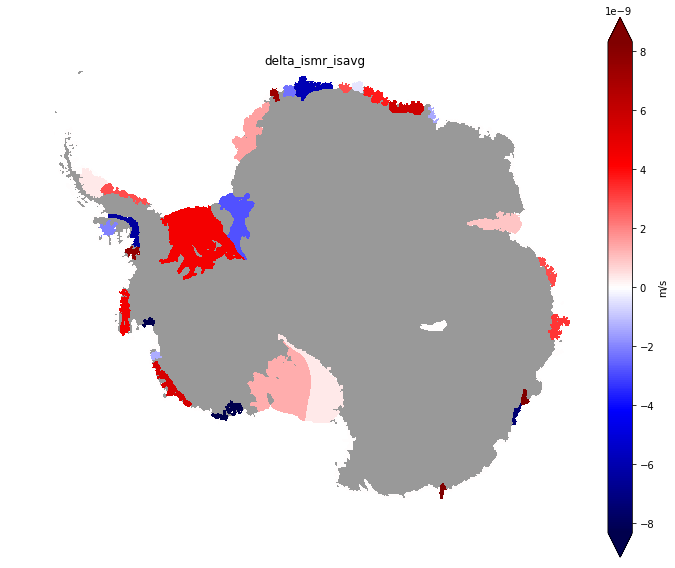

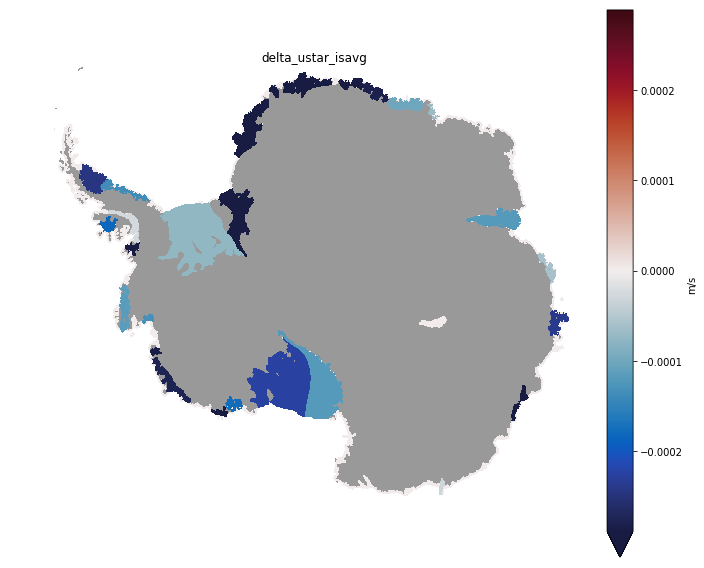

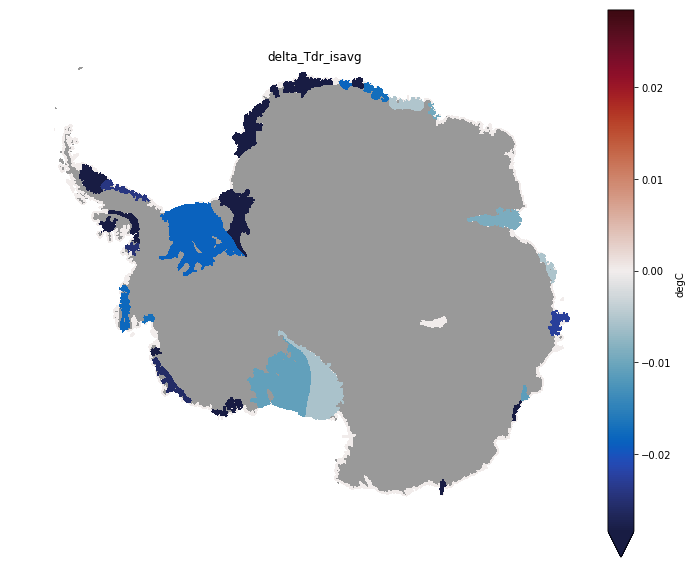

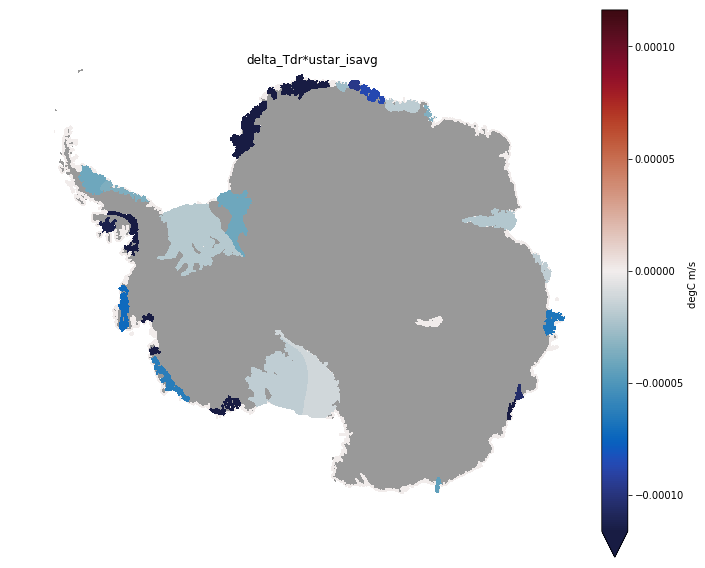

In [130]:
%matplotlib inline
for da,title,cbt,cmap,vrange in zip([avg_map['dm'],avg_map['dustar'],avg_map['dTdr'],avg_map['dTdrUstar']],
                             ['delta_ismr_isavg','delta_ustar_isavg','delta_Tdr_isavg','delta_Tdr*ustar_isavg'],
                             ['m/s','m/s','degC','degC m/s'],
                             [plt.cm.seismic,ocm.balance,ocm.balance,ocm.balance],
                             [None,None,None,None]):
    plot_map(da,grd,title,cbt,cmap,vrange)

In [156]:
def find_sector(shelves_dict,sector_dict):
    for key_shelf,data_shelf in shelves_dict.items():
        mask_shelf = data_shelf['mask']
        nb_shelf = np.count_nonzero(mask_shelf)
        for key_sec,mask_sec in sector_dict.items():
            nb_overlap = np.count_nonzero(mask_sec & mask_shelf)
            if nb_shelf-nb_overlap < (nb_shelf/2):
                shelves_dict[key_shelf]['sector']=key_sec
                continue
    return shelves_dict

sector_masks_path = os.path.join(data_dir,'interim','mask_sector_4.npy') 
sector=np.load(sector_masks_path).item()

big_shelves = find_sector(big_shelves,sector)

In [229]:
big_shelves2 = find_sector(big_shelves2,sector2)

In [231]:
for k,v in big_shelves2.items():
    for name in ['m','ustar','Tdr','TdrUstar']:
        big_shelves[k]['d'+name+'2'] = v['d'+name+'2'] 
        big_shelves[k][name+'2'] = v[name+'2'] 

In [157]:
n = len(sector)-1
colors = iter(plt.cm.rainbow(np.linspace(0,1,n)))
seccol = {} 
for key,data in sector.items():
    if key == 'Total Antarctica': continue
    seccol[key] = next(colors)

In [235]:
matplotlib.rcParams.update({'font.size': 12}) 
def plot_shelves_avg(x_quant,y_quant,title,xlab,ylab,shelves_dict,pertubation):
    
    plt.close()
    fig,ax = plt.subplots(figsize=(12,10))

    for key,data in log_progress(shelves_dict.items(),every=2):
        
        c=seccol[data['sector']]
        
        x1=data[x_quant+pertubation]
        y1=data[y_quant+pertubation]
        
        ax.plot(x1,y1,'o',label=key,c=c)
        ax.annotate(key,(x1,y1),size='x-small')
        
        x2=data[x_quant]
        y2=data[y_quant]
        
        ax.plot(x2,y2,'o',c=c)
        ax.annotate("", xy=(x1,y1), xytext=(x2, y2),
                    arrowprops=dict(arrowstyle="->",color=c))
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title,fontsize=18)
     
    #plt.savefig(os.path.join(fig_dir,'tmp','shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")    
    plt.show()

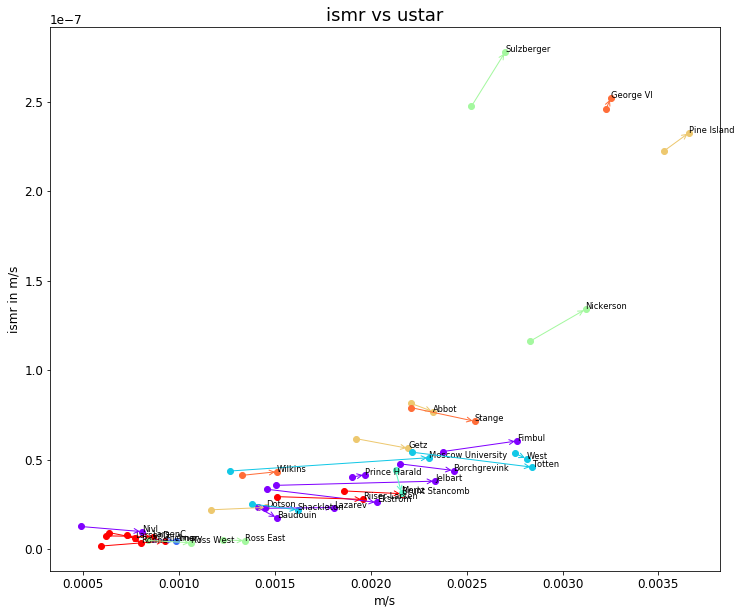

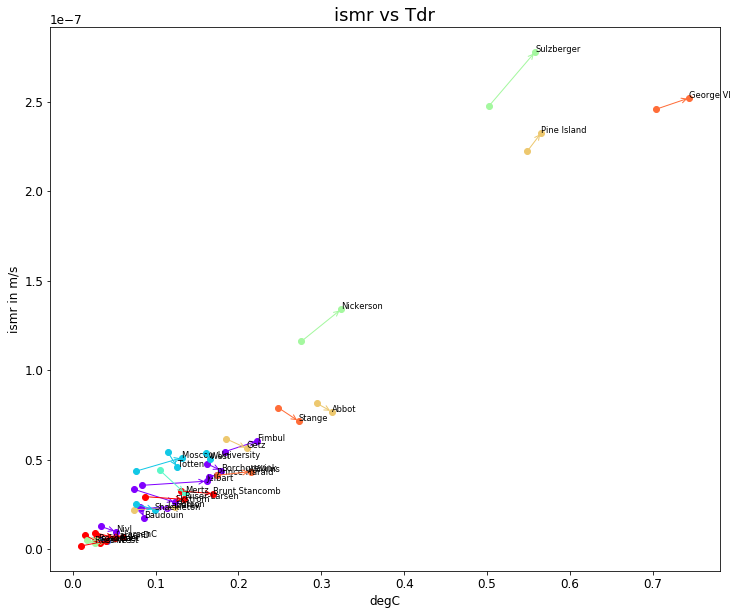

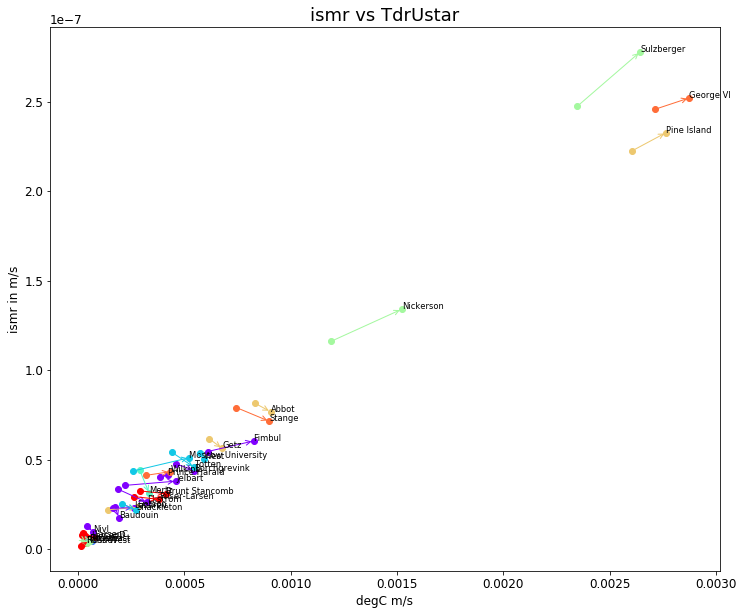

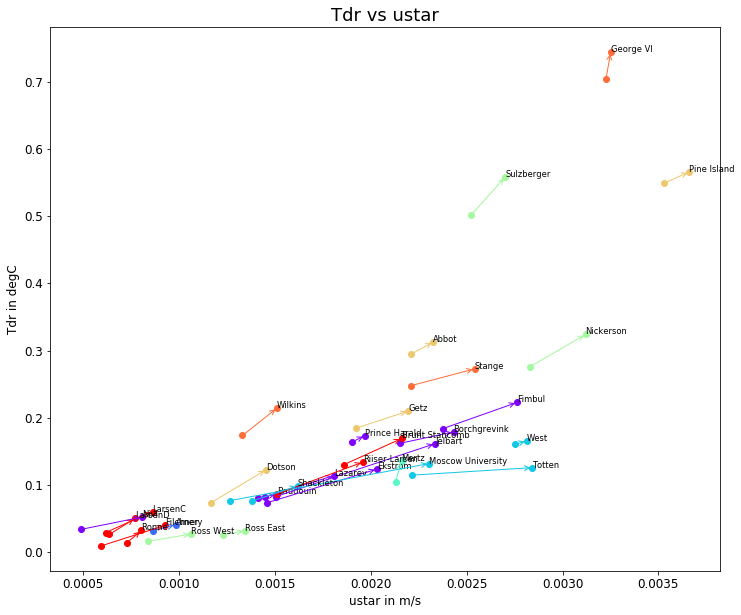

In [237]:
for quant,xlab in zip(['ustar','Tdr','TdrUstar'],
                      ['m/s','degC','degC m/s']):
    plot_shelves_avg(quant,'m','ismr vs '+quant,xlab,'ismr in m/s',big_shelves)
plot_shelves_avg('ustar','Tdr','Tdr vs ustar','ustar in m/s','Tdr in degC',big_shelves)

In [238]:
for quant,xlab in zip(['ustar','Tdr','TdrUstar'],
                      ['m/s','degC','degC m/s']):
    plot_shelves_avg(quant,'m','ismr vs '+quant,xlab,'ismr in m/s',big_shelves,'2')
plot_shelves_avg('ustar','Tdr','Tdr vs ustar','ustar in m/s','Tdr in degC',big_shelves,'2')

TypeError: plot_shelves_avg() takes 6 positional arguments but 7 were given

In [232]:
matplotlib.rcParams.update({'font.size': 12}) 
def plot_shelves_avg(x_quant,y_quant,title,xlab,ylab,shelves_dict):
    
    plt.close()
    fig,ax = plt.subplots(figsize=(12,10))

    for key,data in log_progress(shelves_dict.items(),every=2):
        
        c=seccol[data['sector']]
        
        x1=data[x_quant+'_nt']
        y1=data[y_quant+'_nt']
        
        ax.plot(x1,y1,'o',label=key,c=c)
        ax.annotate(key,(x1,y1),size='x-small')
        
        x2=data[x_quant]
        y2=data[y_quant]
        
        ax.plot(x2,y2,'o',c=c)
        ax.annotate("", xy=(x2,y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle="->",color=c))
        
        x3=data[x_quant+'2']
        y3=data[y_quant+'2']
        
        ax.plot(x3,y3,'o',c=c)
        ax.annotate("", xy=(x3,y3), xytext=(x2, y2),
                    arrowprops=dict(arrowstyle="->",color=c))
        #ax.annotate(key,(x,y),size='x-small')
        #ax.arrow(x1,y1,x2-x1,y2-y1,color='k')
        
        #x_all.append(x2)
        #y_all.append(y2)
    
    #x_all = np.array(x_all).squeeze()
    #y_all = np.array(y_all).squeeze()
    
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x_all, y_all)
    #ax.plot(x_all,slope*x_all+intercept,'gray',label='linear fit',alpha=0.3)
    #ax.text(0.1,0.9,"slope: %.2e    r-squared: %.2f" %(slope, r_value**2),transform=ax.transAxes,fontsize=18)
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title,fontsize=18)
     
    #plt.savefig(os.path.join(fig_dir,'tmp','shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")    
    plt.show()

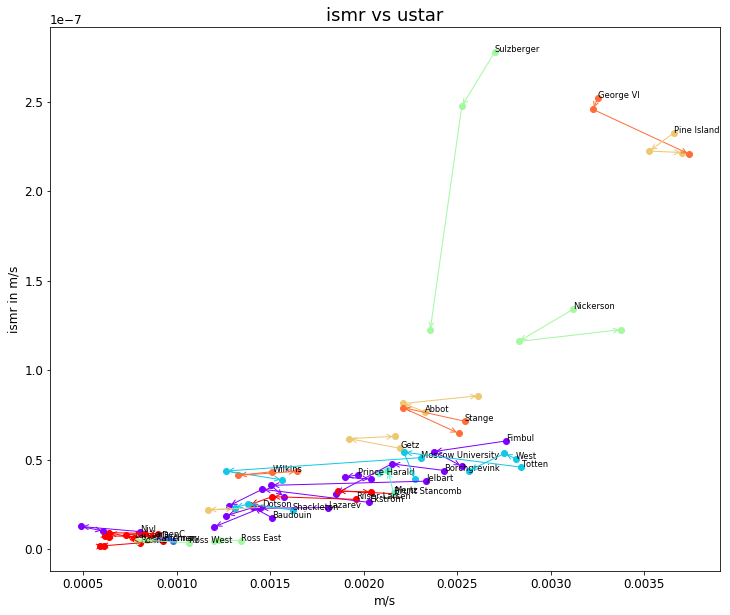

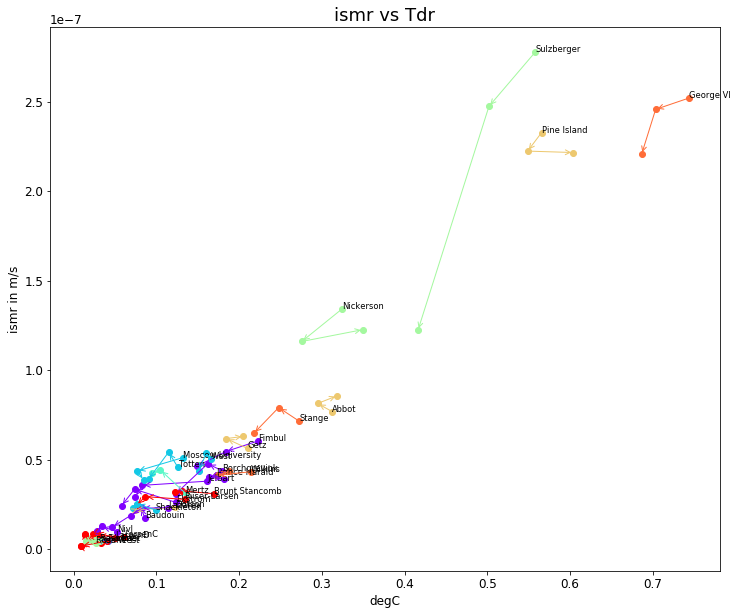

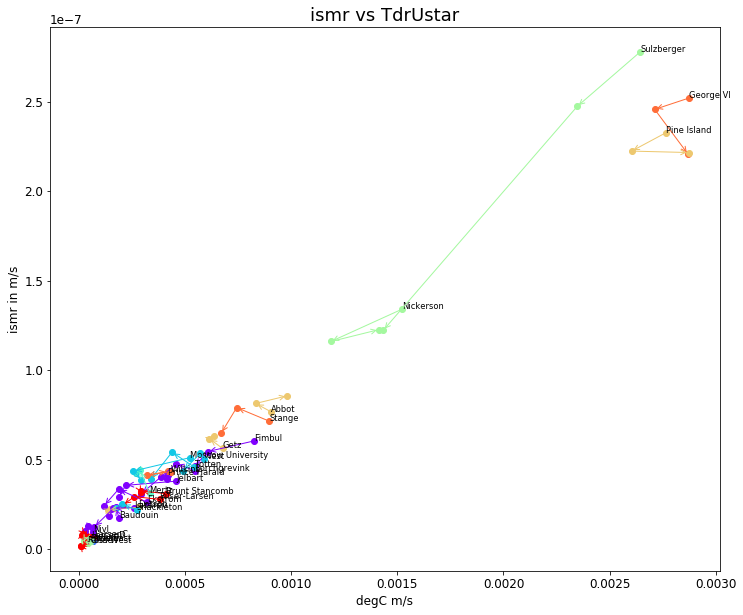

In [233]:
for quant,xlab in zip(['ustar','Tdr','TdrUstar'],
                      ['m/s','degC','degC m/s']):
    plot_shelves_avg(quant,'m','ismr vs '+quant,xlab,'ismr in m/s',big_shelves)

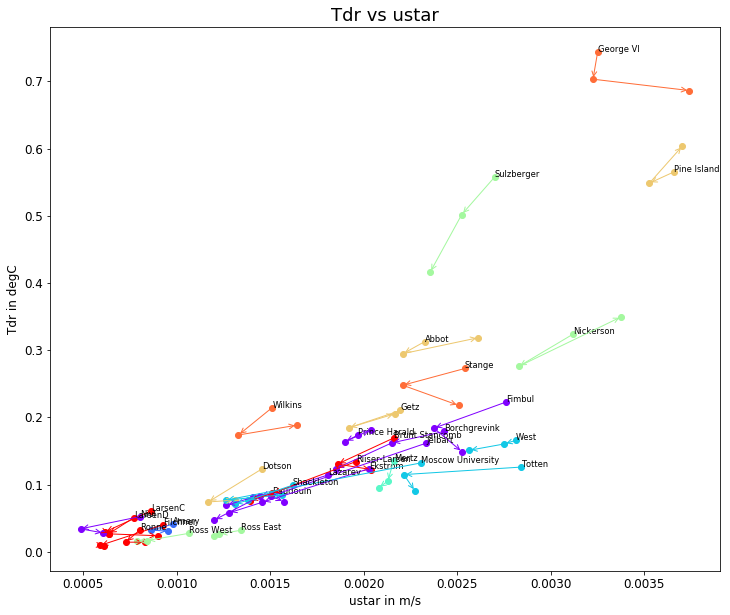

In [234]:
plot_shelves_avg('ustar','Tdr','Tdr vs ustar','ustar in m/s','Tdr in degC',big_shelves)

In [188]:
matplotlib.rcParams.update({'font.size': 12}) 
def plot_shelves_davg(x_quant,y_quant,title,xlab,ylab,shelves_dict):
    
    plt.close()
    fig,ax = plt.subplots(figsize=(12,10))
    
    x_all = []
    y_all = []

    for key,data in log_progress(shelves_dict.items(),every=2):
        
        c=seccol[data['sector']]
        
        x=data[x_quant]
        y=data[y_quant]
        
        ax.plot(x,y,'o',label=key,c=c)
        ax.annotate(key,(x,y),size='x-small')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title,fontsize=18)
     
    plt.savefig(os.path.join(fig_dir,'tmp','shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")    
    print(os.path.join(fig_dir,'tmp','shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'))
    plt.show()

../../reports/figures/tmp/shelfavg__delta_ismr_vs_dustar.png


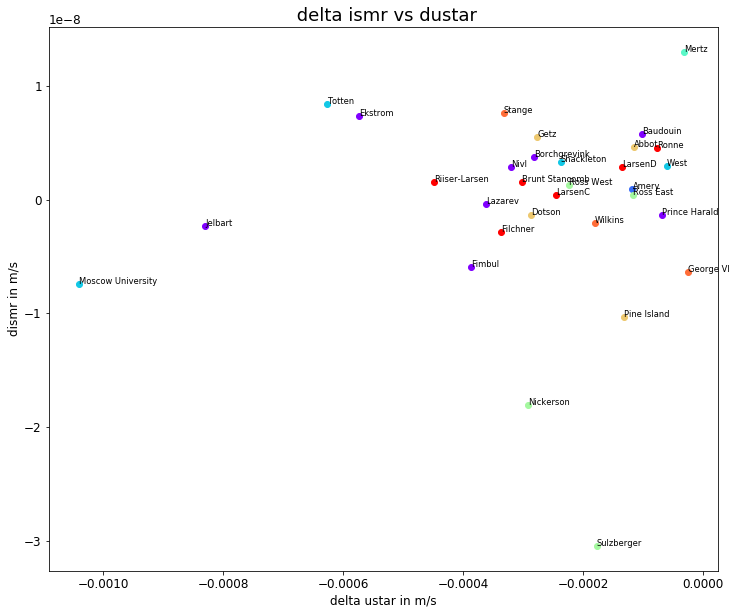

../../reports/figures/tmp/shelfavg__delta_ismr_vs_dTdr.png


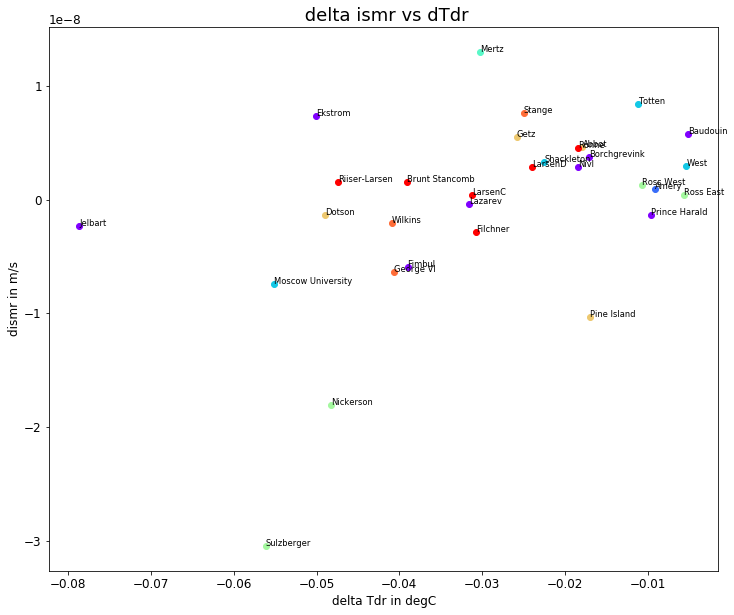

../../reports/figures/tmp/shelfavg__delta_ismr_vs_dTdrUstar.png


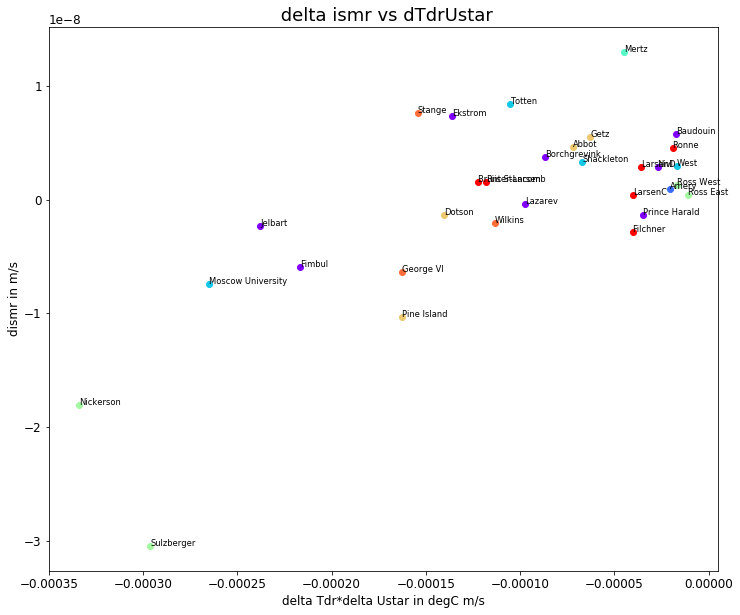

In [189]:
for quant,xlab in zip(['dustar','dTdr','dTdrUstar'],
                      ['delta ustar in m/s','delta Tdr in degC','delta Tdr*delta Ustar in degC m/s']):
    plot_shelves_davg(quant,'dm',' delta ismr vs '+quant,xlab,'dismr in m/s',big_shelves)

../../reports/figures/tmp/shelfavg_delta_Tdr_over_delta_ustar.png


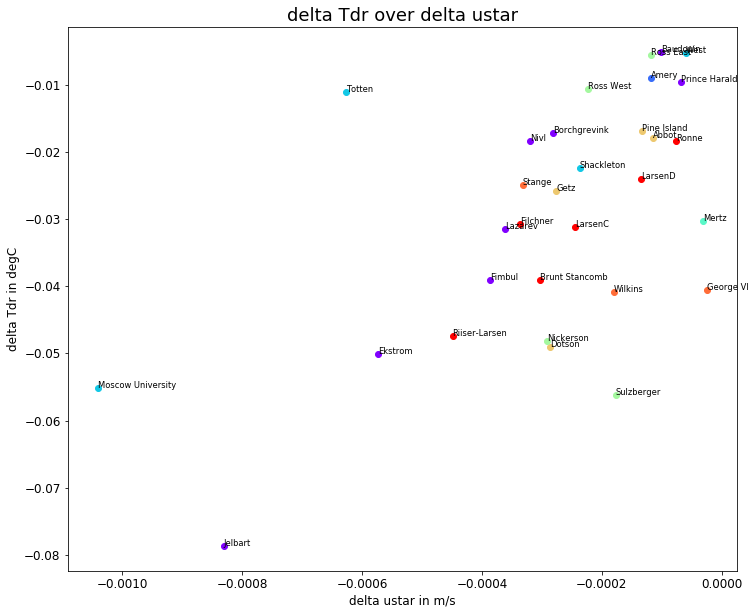

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:52670 remote=tcp://127.0.0.1:48331>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39978 remote=tcp://127.0.0.1:33269>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:52671 remote=tcp://127.0.0.1:48331>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39981 remote=tcp://127.0.0.1:33269>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39985 remote=tcp://127.0.0.1:33269>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39986 remote=tcp://127.0.0.1:33269>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39987 remote=tcp://127.0.0.1:33269>


In [190]:
plot_shelves_davg('dustar','dTdr','delta Tdr over delta ustar','delta ustar in m/s','delta Tdr in degC',big_shelves)